# 2. Model Building and Evaluation

### 0. Imports

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import cv2 as cv
from utils import *
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost

/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load in Processed Images

In [2]:
cwd = os.getcwd()
data_path = os.path.join(cwd,'standardized_data/Training')

X = []
y = []

for label in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path,label)):
        image_path = os.path.join(data_path,label,image)
        load_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        # flatten_image = load_image.flatten()
        X.append(load_image)
        y.append(label)


# Convert to Numpy Array
X = np.array(X)
y = np.array(y)
le = LabelEncoder()
le.fit(y) 
y = le.transform(y)

print(X.shape)
print(y.shape)

print(X[0])
print(y[0])

(5712, 512, 512)
(5712,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3


### 2. Base Model (most common class classifier)

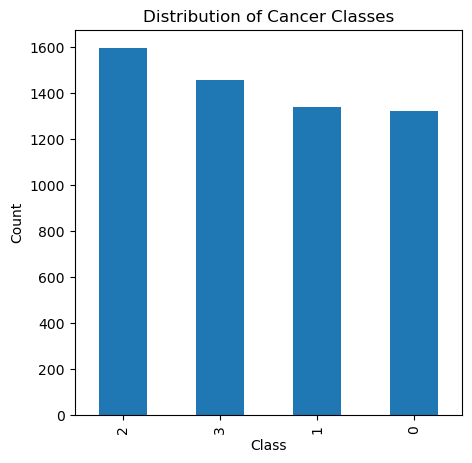

['glioma' 'meningioma' 'notumor' 'pituitary']


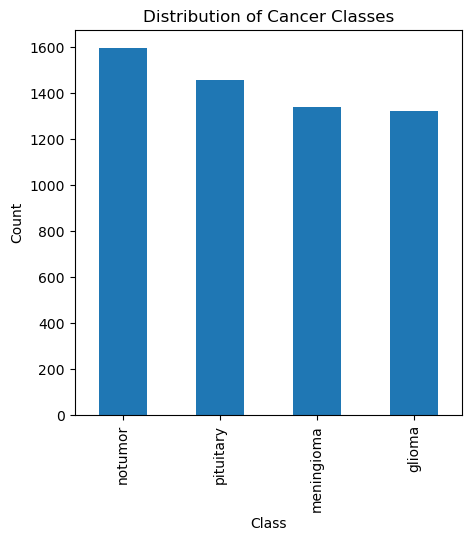

Most Common Label: 2
(5712,)
(5712,)


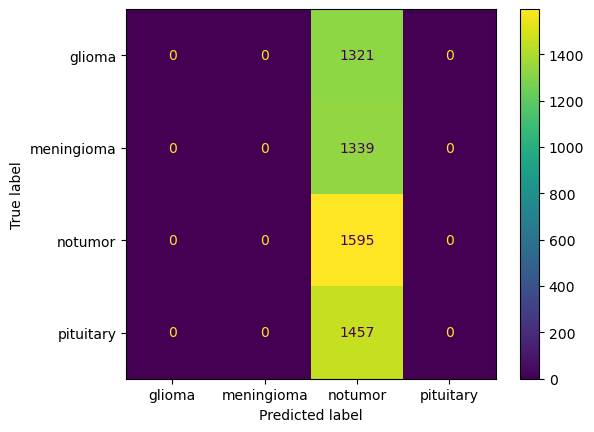

================== TRAINING METRICS ===================
Accuracy Score: 0.27923669467787116
Macro Precision: 0.06980917366946779
Macro Recall: 0.25
Macro F1: 0.10914191870808813
Micro Precision: 0.27923669467787116
Micro Recall: 0.27923669467787116
Micro F1: 0.27923669467787116


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
plt.figure(figsize=(5,5))
y_train_series = pd.Series(y)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print(le.classes_)
y_transformed = le.inverse_transform(y)

plt.figure(figsize=(5,5))
y_train_series = pd.Series(y_transformed)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Generate Model Statistics
most_common_label = stats.mode(y)[0]
print("Most Common Label: " + str(most_common_label))
y_predict = np.ones((y.shape)) * most_common_label
print(y_predict.shape)
print(y.shape)

# Generate Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = le.classes_)
cm_display.plot()
plt.show()

accuracy_score = metrics.accuracy_score(y, y_predict)
macro_precision = metrics.precision_score(y,y_predict,average ='macro')
macro_recall = metrics.recall_score(y,y_predict,average='macro')
macro_f1 = metrics.f1_score(y,y_predict,average='macro')
micro_precision = metrics.precision_score(y,y_predict,average='micro')
micro_recall = metrics.recall_score(y,y_predict,average='micro')
micro_f1 = metrics.f1_score(y,y_predict,average='micro')

print("================== TRAINING METRICS ===================")
print("Accuracy Score: " + str(accuracy_score))
print("Macro Precision: " + str(macro_precision))
print("Macro Recall: " + str(macro_recall))
print("Macro F1: " + str(macro_f1))
print("Micro Precision: " + str(micro_precision))
print("Micro Recall: " + str(micro_recall))
print("Micro F1: " + str(micro_f1))

### 3. Extract Features (Canny Edges, Difference of Gaussians, Complex Feature)
- Commented out as feature generation takes a long time (>1 hour). We saved the features into numpy files as well as csv to load in for training later.

In [4]:
# ### TBD
# X_dog_features = get_features(X, feat_name='blob_dog')
# X_doh_features = get_features(X, feat_name='blob_doh')
# X_canny_features = get_features(X, feat_name='canny')
# pca = PCA(n_components=1000, svd_solver="randomized", whiten=True).fit(X_canny_features)
# X_pca_canny_features = pca.transform(X_canny_features)
# # X_complex_features = get_features(X, feat_name='complex')

# np.save('X_train_dog_features.npy', X_dog_features)
# np.save('X_train_doh_features.npy', X_doh_features)
# np.save('X_train_pca_canny_features.npy', X_pca_canny_features)
# # np.save('X_train_complex_features.npy', X_complex_features)
# np.save('Y_train.npy',y)
# y_raw_train = le.inverse_transform(y)
# np.save('Y_raw_train.npy',y_raw_train)
# print(y.shape)
# print(y_raw_train.shape)

### 3a. Load Features

In [5]:
aligned_train_features = pd.read_csv('extracted_features/aligned_training_features.csv')
aligned_train_features, dims, enc = clean_df(
    df=aligned_train_features,
    label_col="target",
    feat_cols=["feat_canny", "feat_vec", "feat_dog", "feat_doh"]
)

parsed_aligned_train_features  = parse_aligned_features(aligned_train_features, ['feat_canny', 'feat_vec', 'feat_dog', 'feat_doh'])

# Feature Loading
X_dog_features = parsed_aligned_train_features['feat_dog']
X_doh_features = parsed_aligned_train_features['feat_doh']
X_complex_features = parsed_aligned_train_features['feat_vec']
X_train_pca_canny_features = np.load('extracted_features/X_train_pca_canny_features.npy')

# Label Loading
y_train = parsed_aligned_train_features['target']


### 3a. PCA/tSNE

- See [blob_detection.ipynb](./blob_detection.ipynb) for DoG and DoH PCA and tSNE Plots
- See [canny_edges.ipynb](./canny_edges.ipynb) for Canny edges PCA and tSNE Plots

In [6]:
# x = plot_PCA([X_dog_features, X_doh_features, X_train_pca_canny_features, X_complex_features], n_components=[min(X_dog_features.shape), min(X_doh_features.shape), 1000, min(X_complex_features.shape)])


### 4. Shuffle Data

In [7]:
np.random.seed(281)

# Create a list of indexes that is the length of the number of training examples
indices = [i for i in range(0,X.shape[0])]
shuffle_indices = np.random.permutation(indices)

X_dog_features = X_dog_features[shuffle_indices]
X_doh_features = X_doh_features[shuffle_indices]
X_canny_features = X_train_pca_canny_features[shuffle_indices]
X_complex_features = X_complex_features[shuffle_indices]

y_train = y_train[shuffle_indices]

In [8]:
print(X_dog_features.shape)
print(X_dog_features.shape)
print(X_canny_features.shape)
print(X_complex_features.shape)

(5712, 14)
(5712, 14)
(5712, 1000)
(5712, 768)


### 5. Model Training

Fitting 5 folds for each of 4 candidates, totalling 20 fits


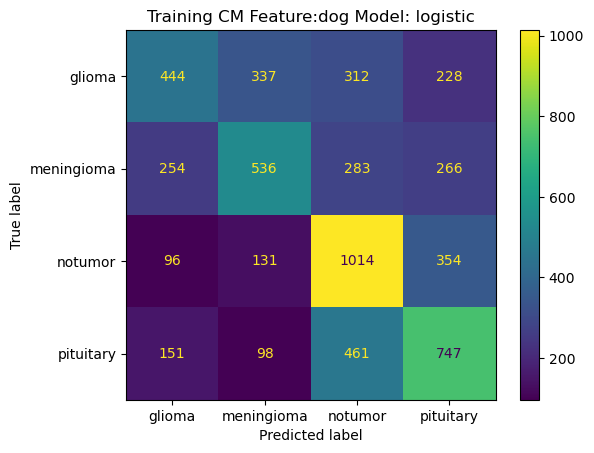

(5712, 4)


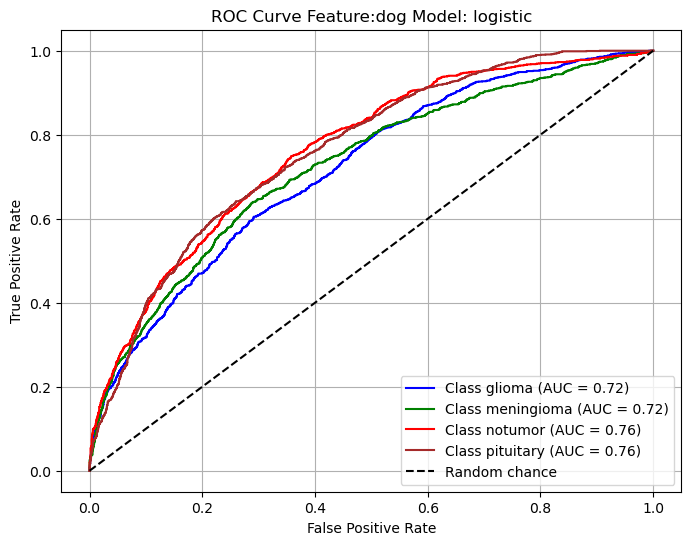

Fitting 5 folds for each of 4 candidates, totalling 20 fits


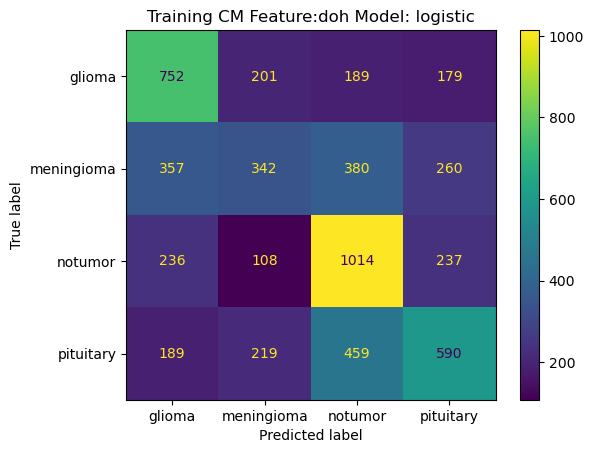

(5712, 4)


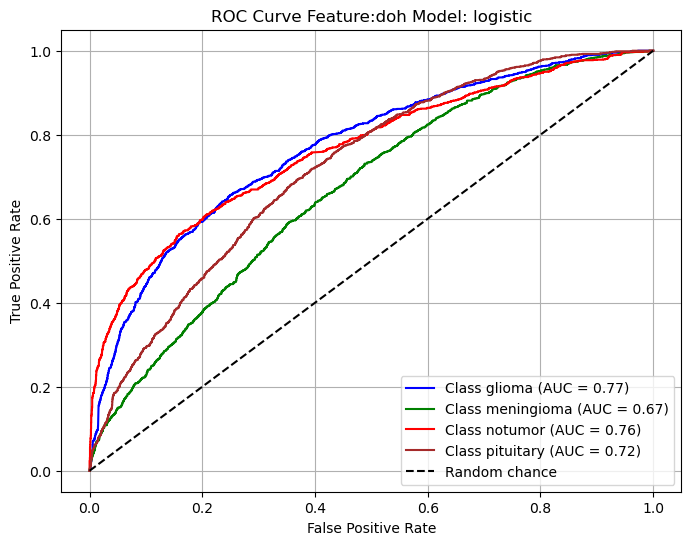

Fitting 5 folds for each of 4 candidates, totalling 20 fits


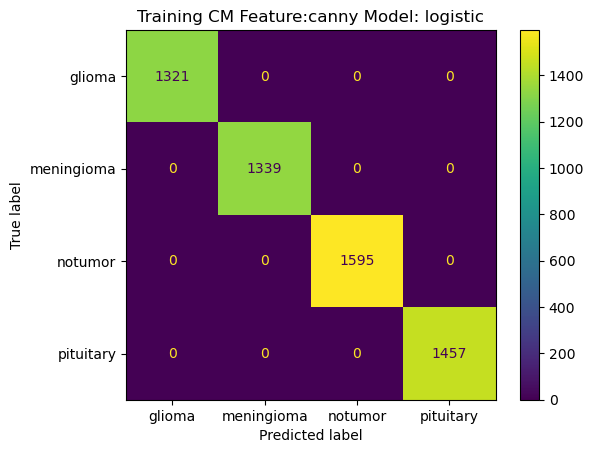

(5712, 4)


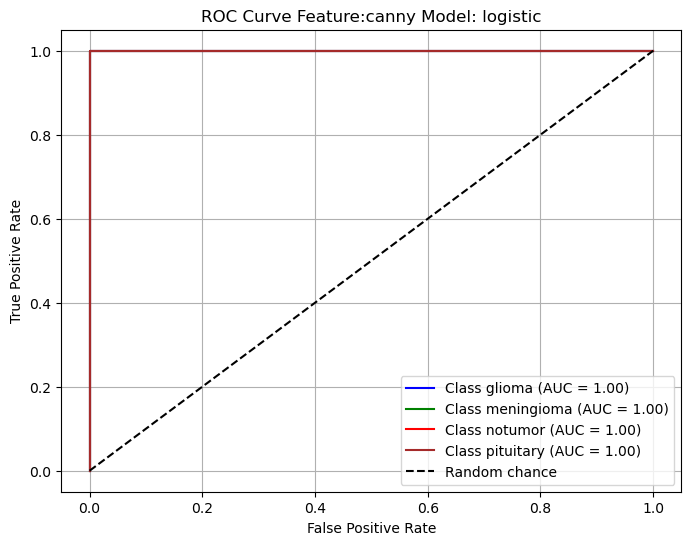

Fitting 5 folds for each of 4 candidates, totalling 20 fits


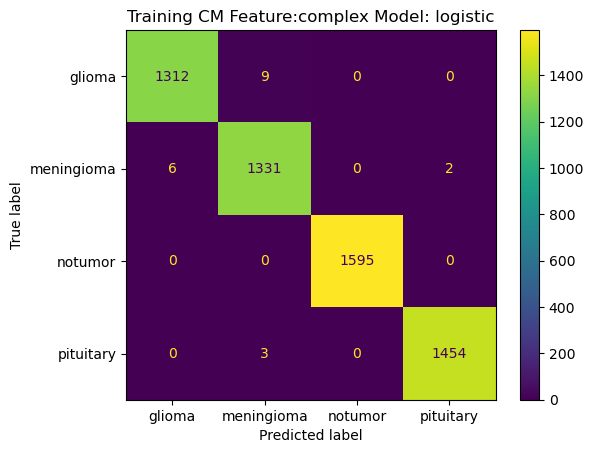

(5712, 4)


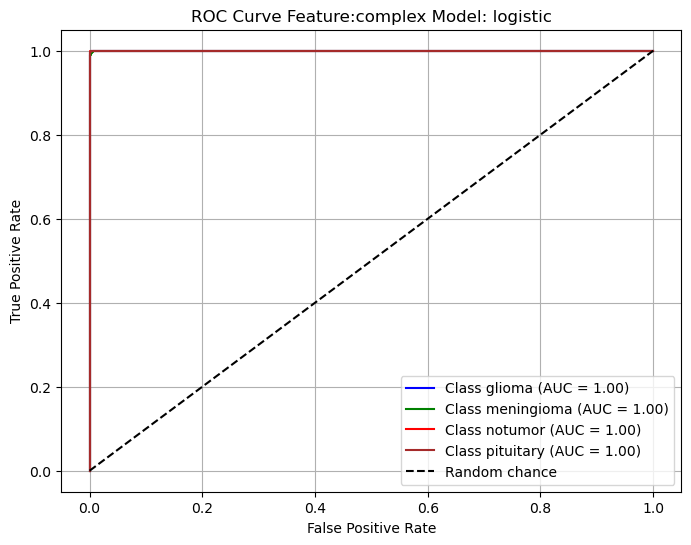

Fitting 5 folds for each of 4 candidates, totalling 20 fits


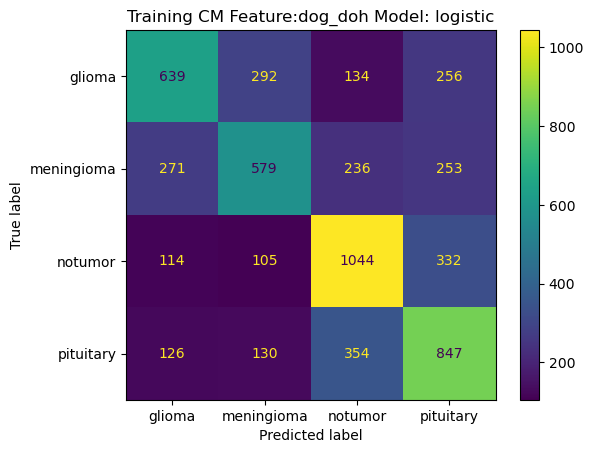

(5712, 4)


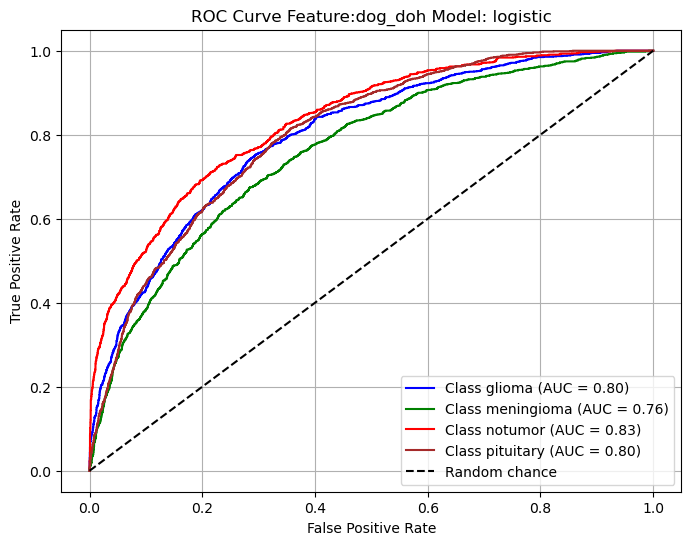

Fitting 5 folds for each of 4 candidates, totalling 20 fits


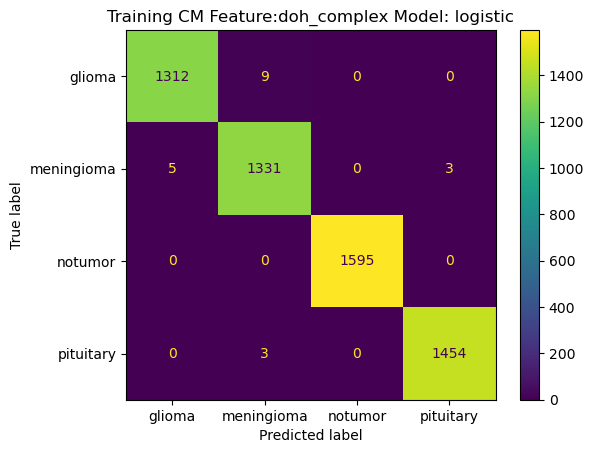

(5712, 4)


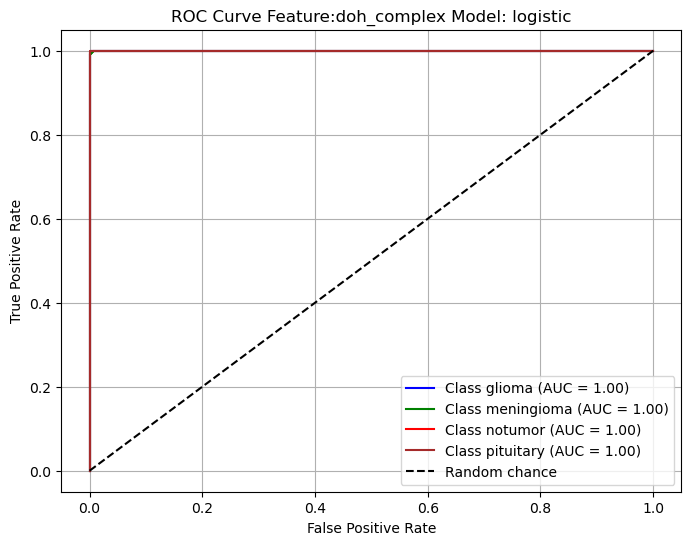

Fitting 5 folds for each of 4 candidates, totalling 20 fits


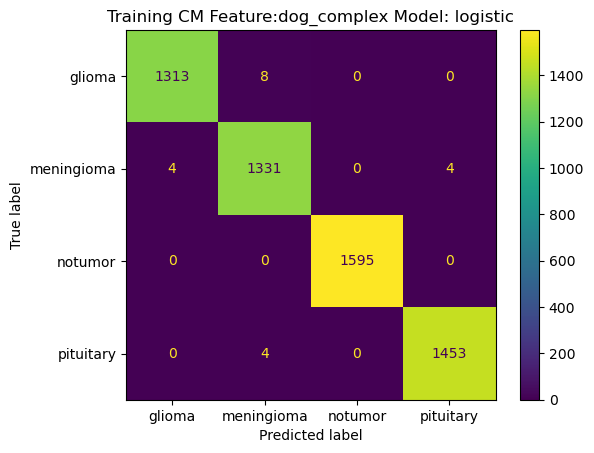

(5712, 4)


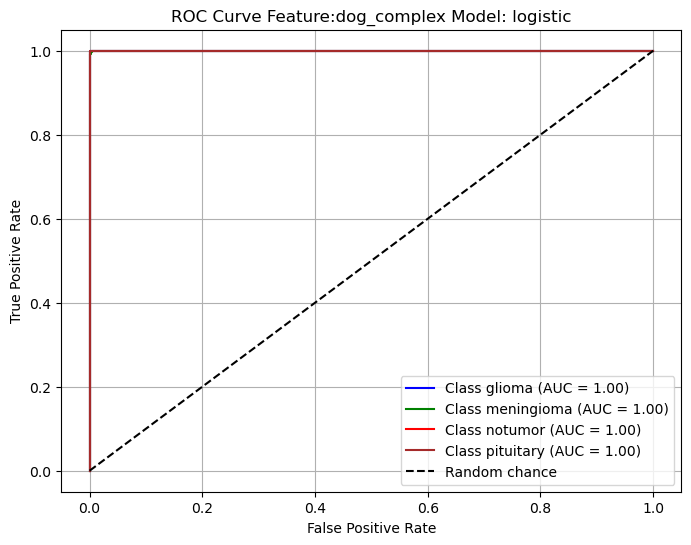

Fitting 5 folds for each of 4 candidates, totalling 20 fits


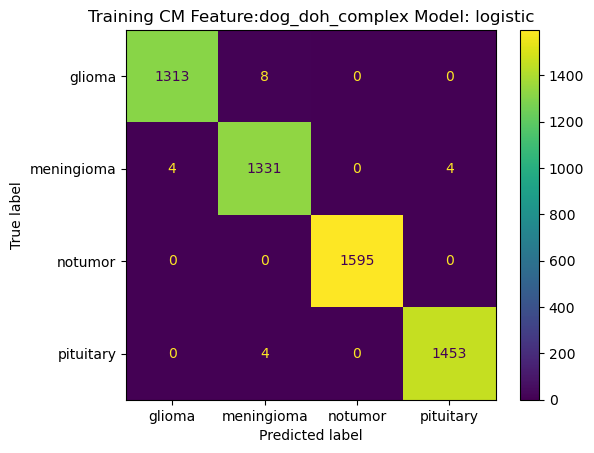

(5712, 4)


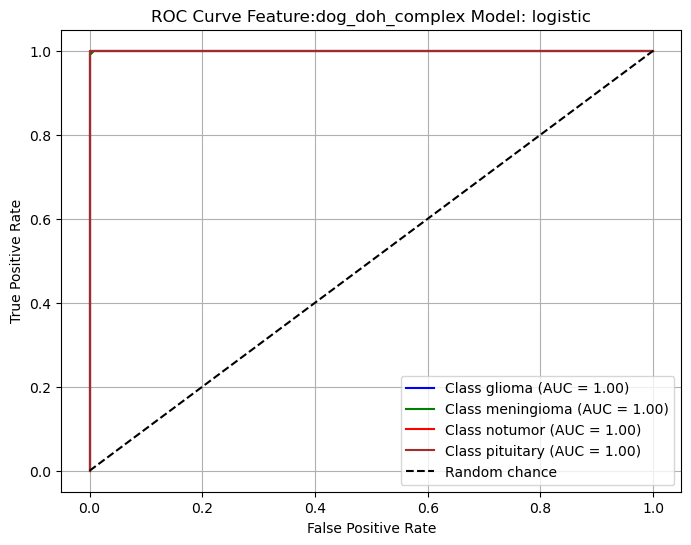

saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog to path=models/logistic_dog.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh to path=models/logistic_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_canny to path=models/logistic_canny.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_complex to path=models/logistic_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh to path=models/logistic_dog_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh_complex to path=models/logistic_doh_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_complex to path=models/logistic_dog_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh_complex to path=models/logistic_dog_doh_complex.job

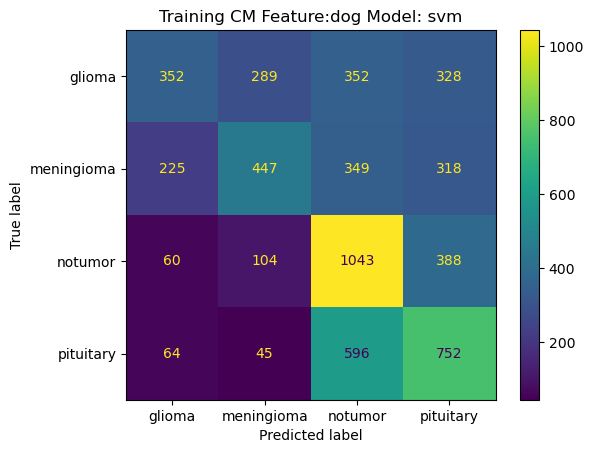

(5712, 4)


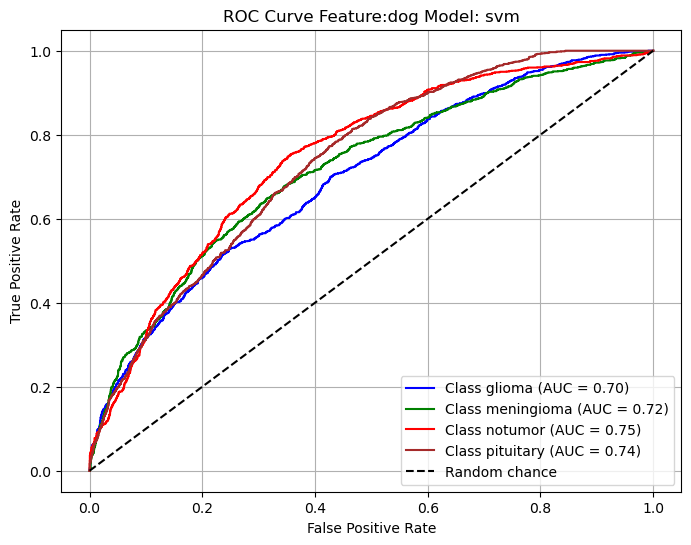

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   4.5s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   4.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   4.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   4.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   4.4s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   3.1s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   3.1s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   3.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   3.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   3.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.1s
[CV] END .......................C=0.1, gamma=0.1,

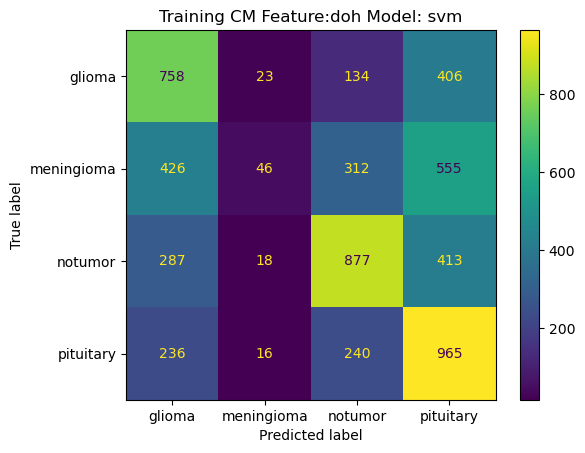

(5712, 4)


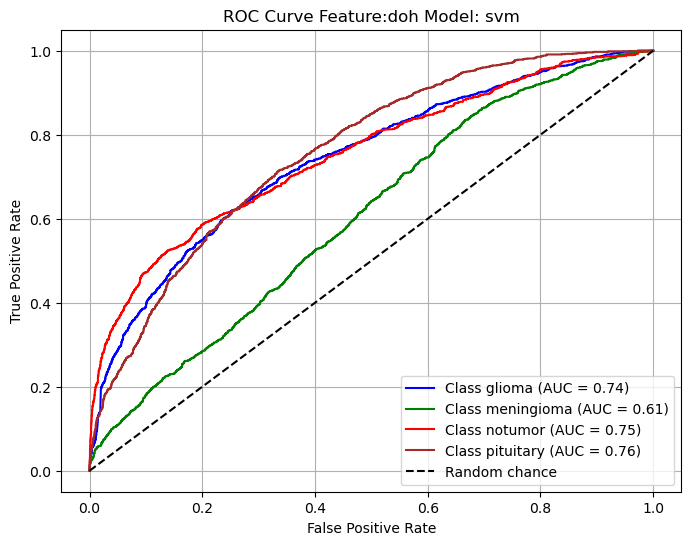

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  50.8s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  47.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  48.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  48.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  48.4s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  23.9s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  23.8s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  23.6s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  23.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=  23.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 1.1min
[CV] END .......................C=0.1, gamma=0.1,

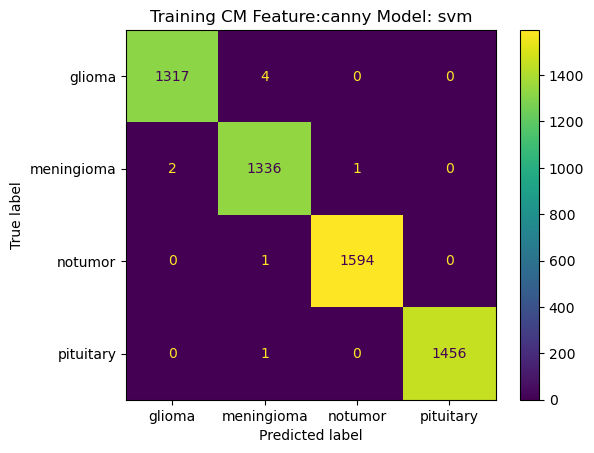

(5712, 4)


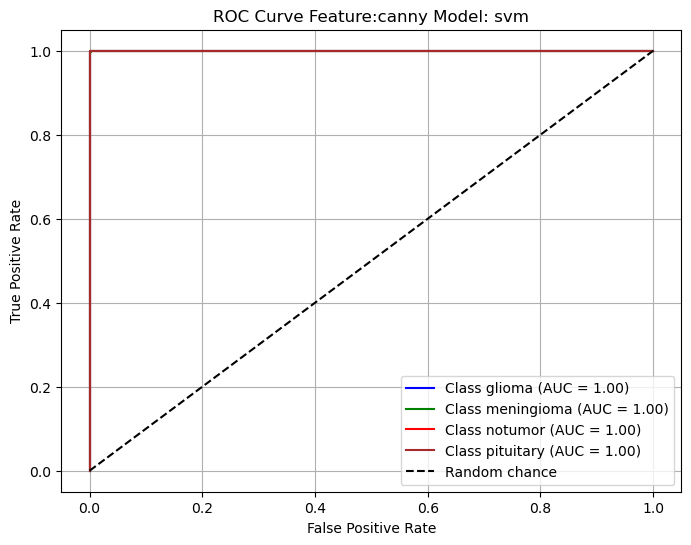

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.5s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.2s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.3s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.4s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.1s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.3s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  48.1s
[CV] END .......................C=0.1, gamma=0.1,

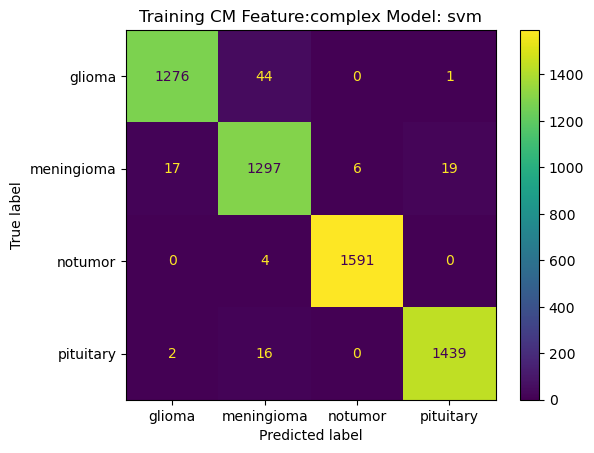

(5712, 4)


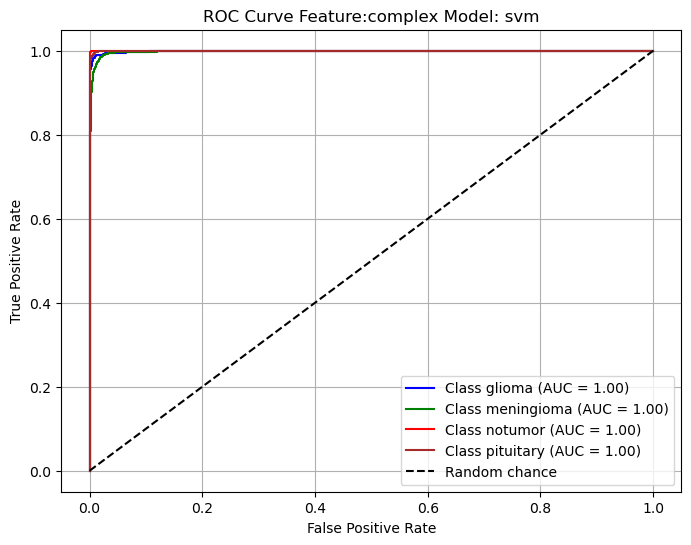

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   6.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   6.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   6.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   6.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   6.6s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   6.0s
[CV] END .......................C=0.1, gamma=0.1,

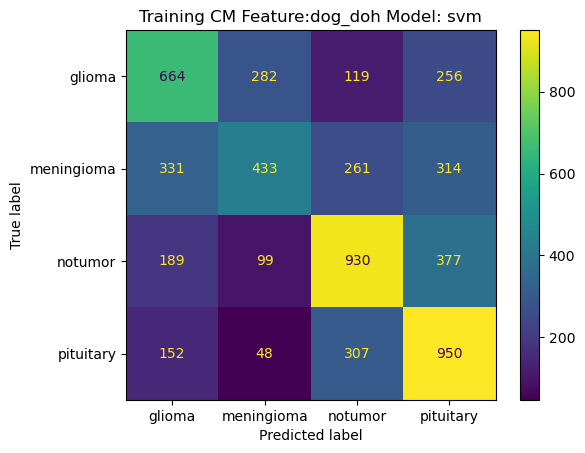

(5712, 4)


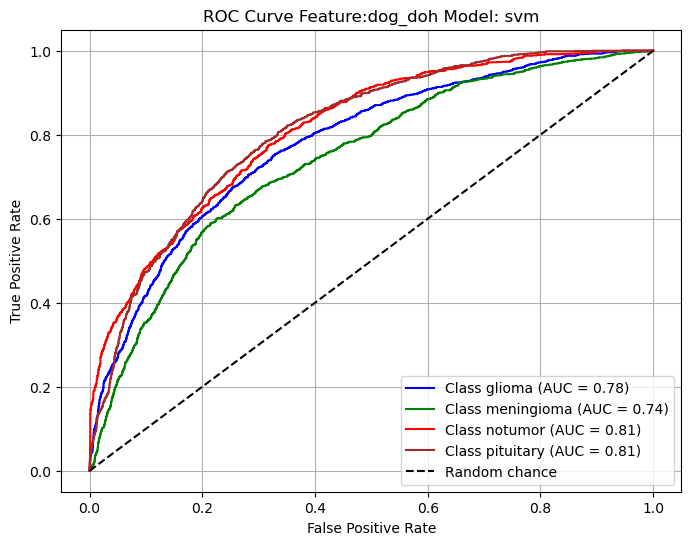

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  34.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  30.9s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  30.9s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  30.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.6s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.4s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.6s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  49.7s
[CV] END .......................C=0.1, gamma=0.1,

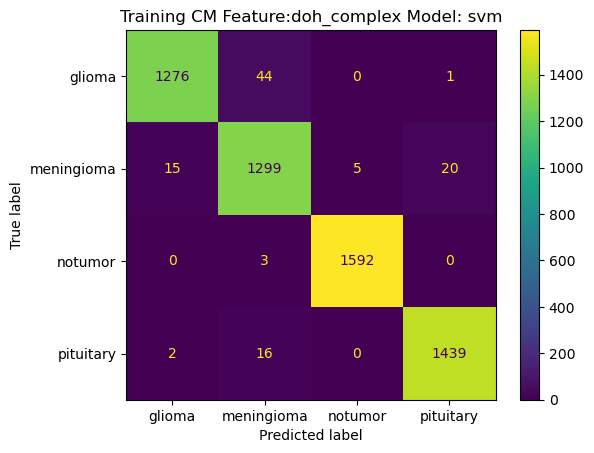

(5712, 4)


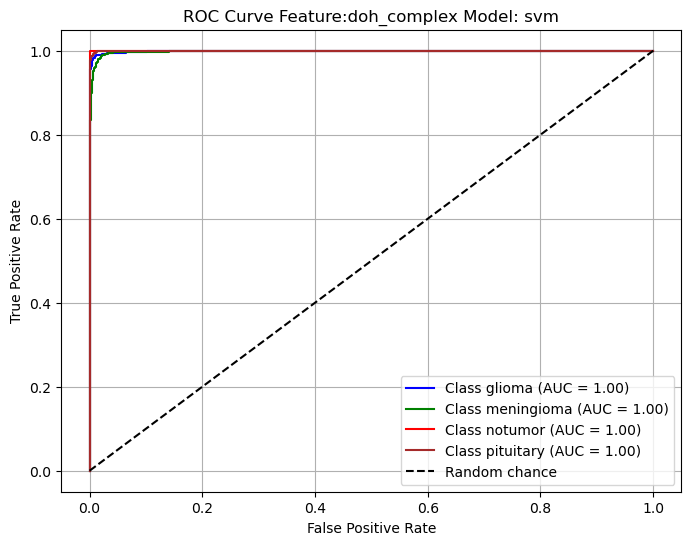

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.8s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.8s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.4s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.2s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  50.2s
[CV] END .......................C=0.1, gamma=0.1,

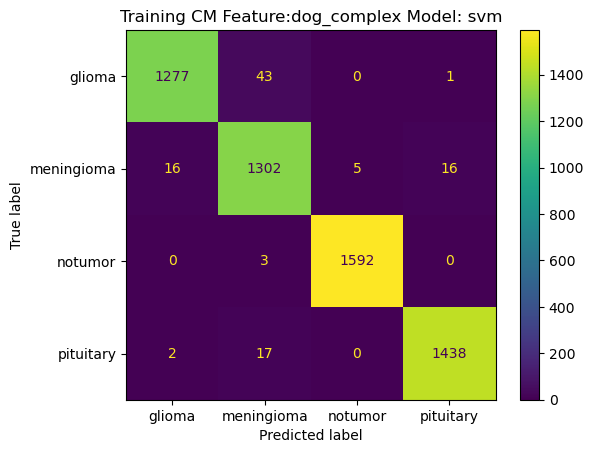

(5712, 4)


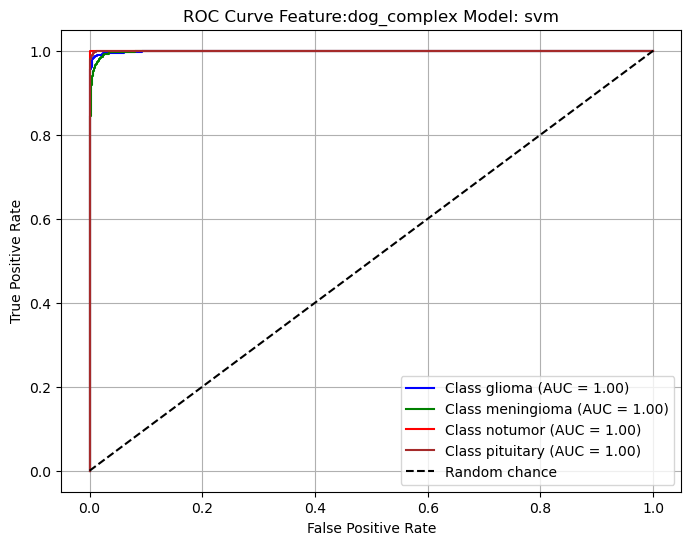

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  32.8s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.9s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.9s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.8s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   6.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  58.3s
[CV] END .......................C=0.1, gamma=0.1,

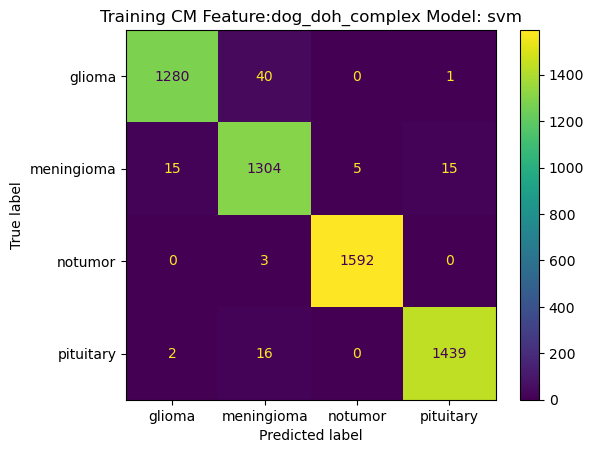

(5712, 4)


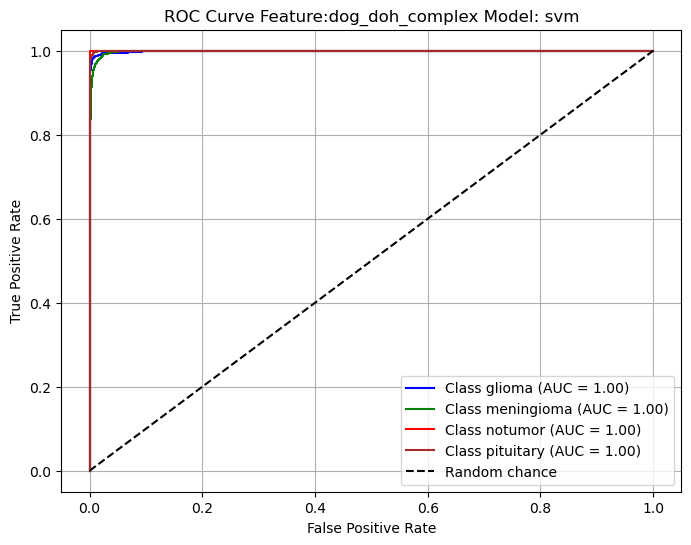

saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog to path=models/logistic_dog.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh to path=models/logistic_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_canny to path=models/logistic_canny.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_complex to path=models/logistic_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh to path=models/logistic_dog_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh_complex to path=models/logistic_doh_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_complex to path=models/logistic_dog_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh_complex to path=models/logistic_dog_doh_complex.job

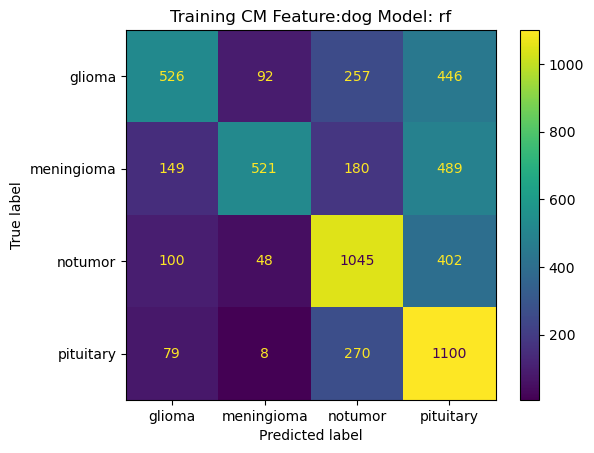

(5712, 4)


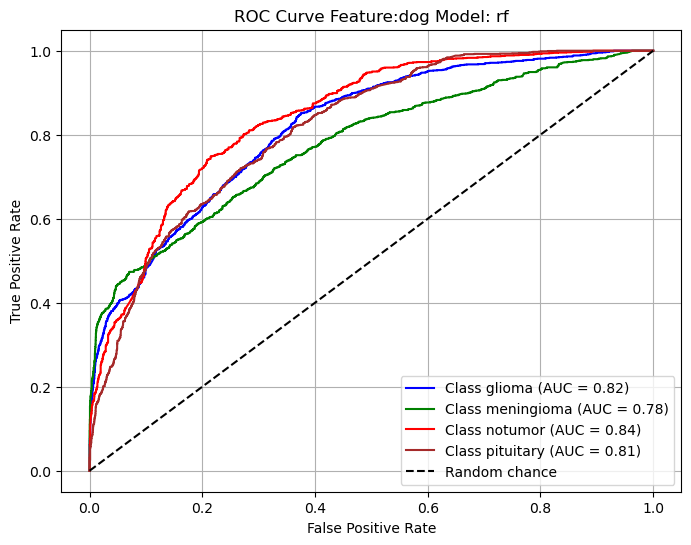

Fitting 5 folds for each of 24 candidates, totalling 120 fits


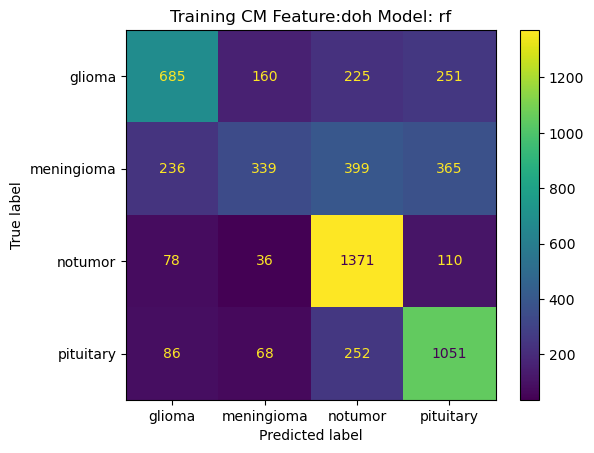

(5712, 4)


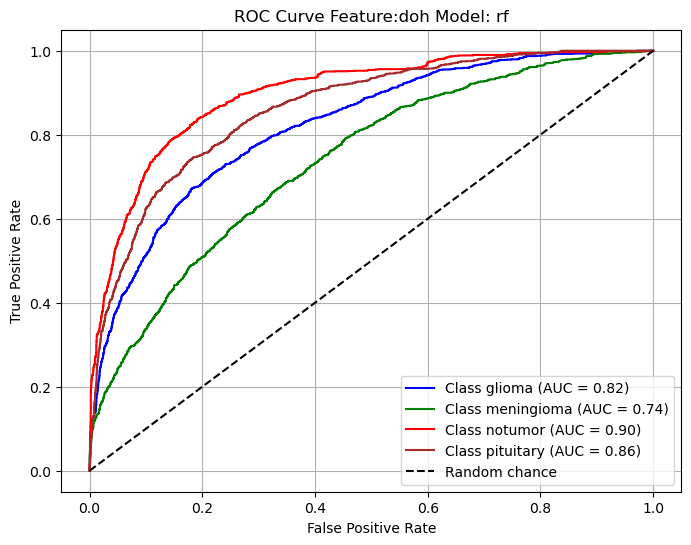

Fitting 5 folds for each of 24 candidates, totalling 120 fits


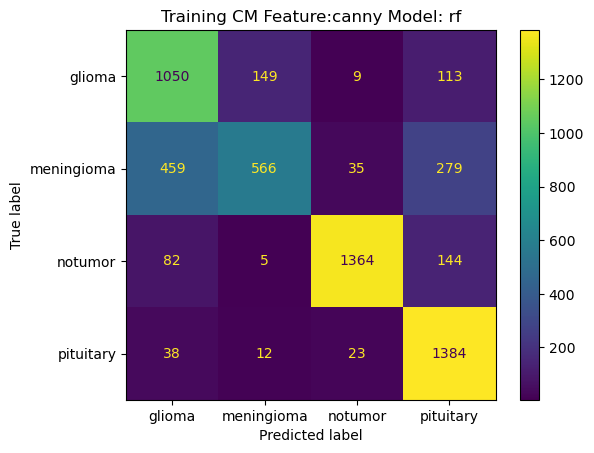

(5712, 4)


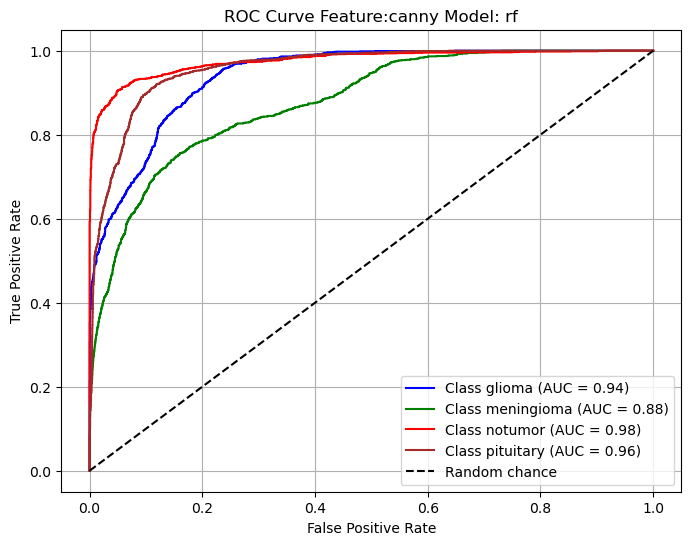

Fitting 5 folds for each of 24 candidates, totalling 120 fits


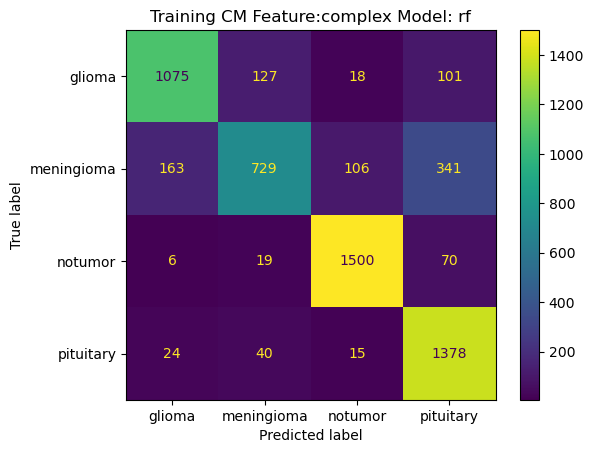

(5712, 4)


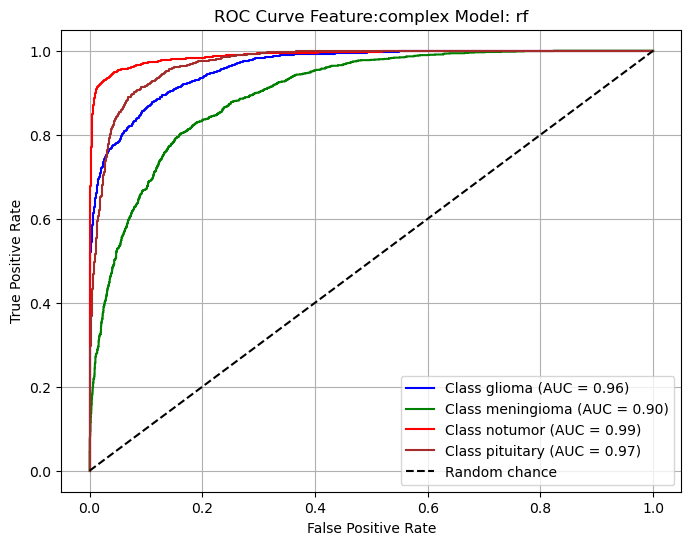

Fitting 5 folds for each of 24 candidates, totalling 120 fits


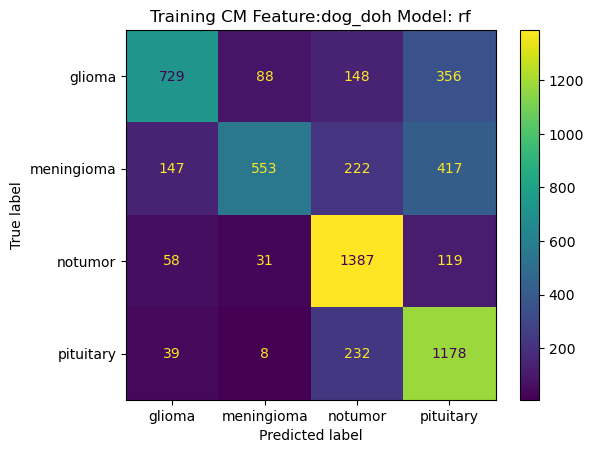

(5712, 4)


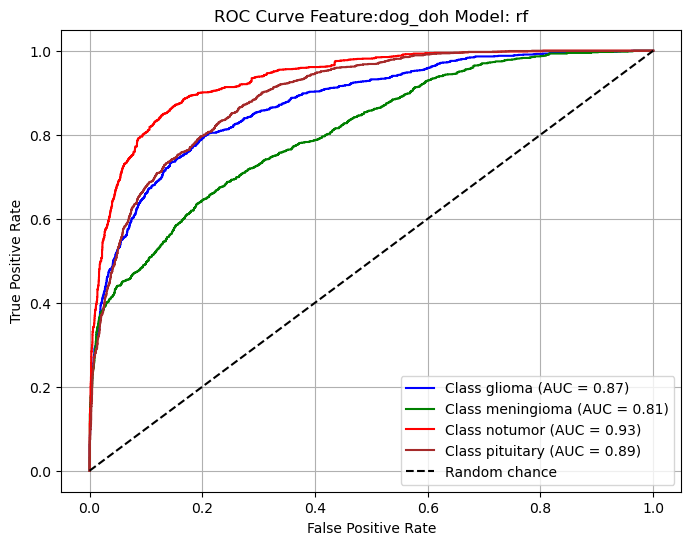

Fitting 5 folds for each of 24 candidates, totalling 120 fits


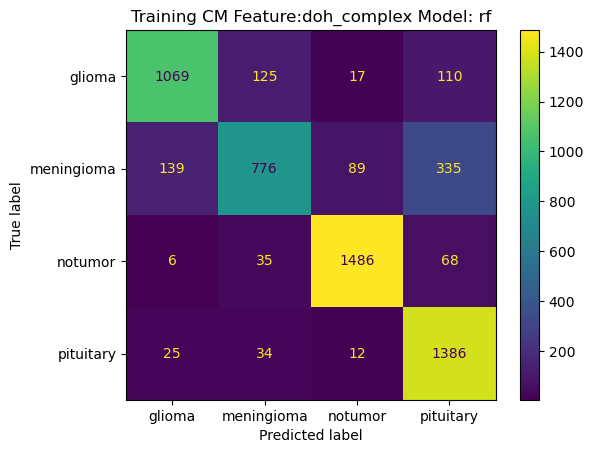

(5712, 4)


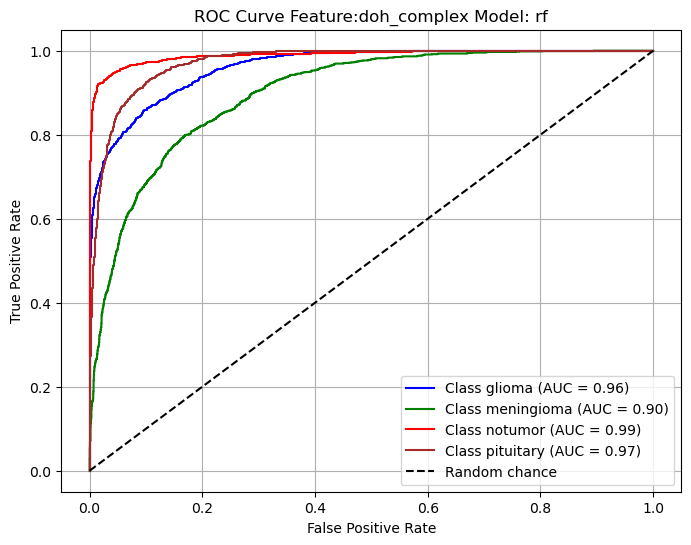

Fitting 5 folds for each of 24 candidates, totalling 120 fits


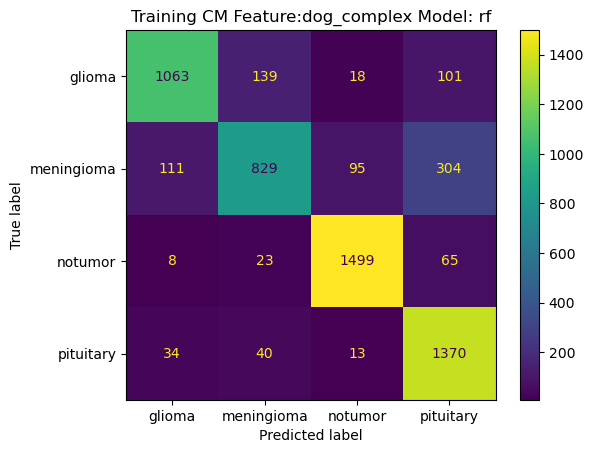

(5712, 4)


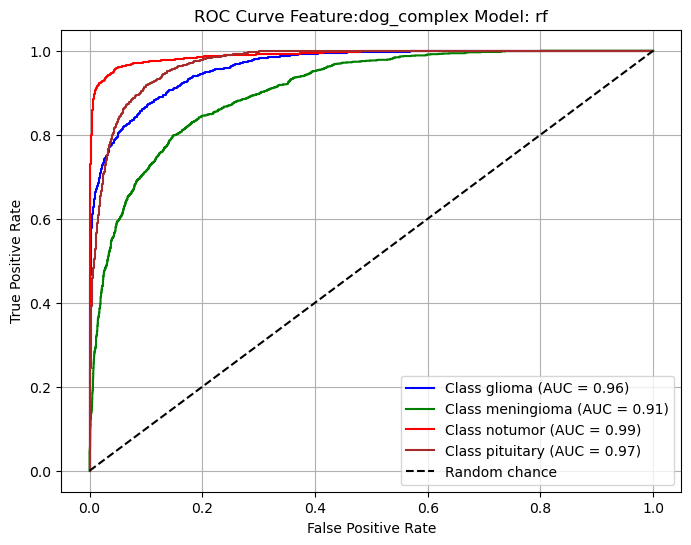

Fitting 5 folds for each of 24 candidates, totalling 120 fits


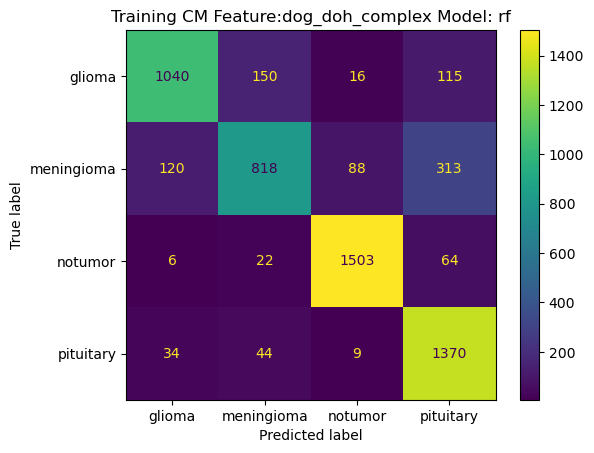

(5712, 4)


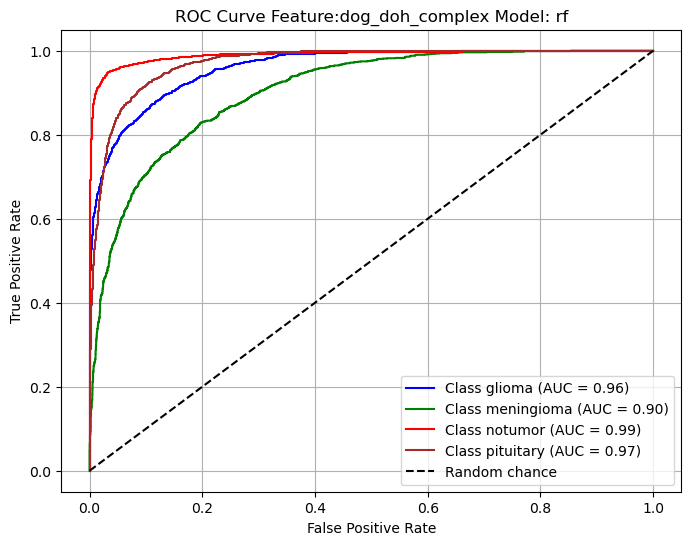

saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog to path=models/logistic_dog.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh to path=models/logistic_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_canny to path=models/logistic_canny.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_complex to path=models/logistic_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh to path=models/logistic_dog_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh_complex to path=models/logistic_doh_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_complex to path=models/logistic_dog_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh_complex to path=models/logistic_dog_doh_complex.job

/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

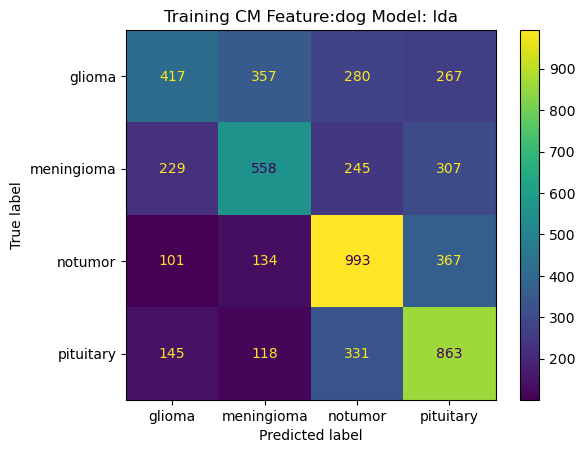

(5712, 4)


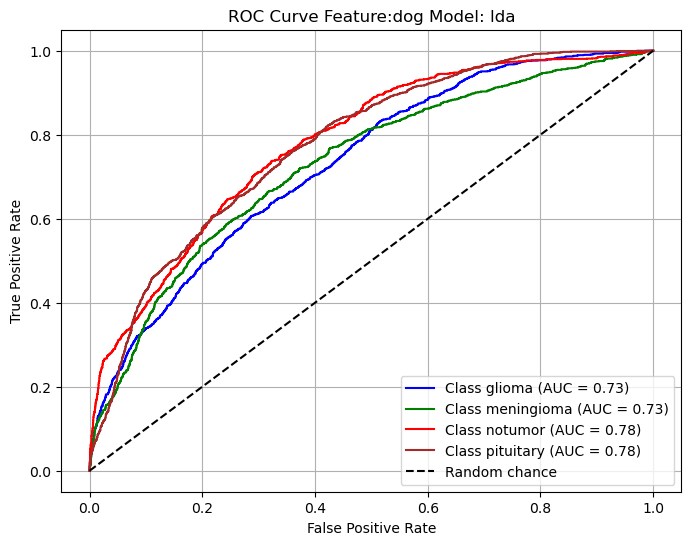

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

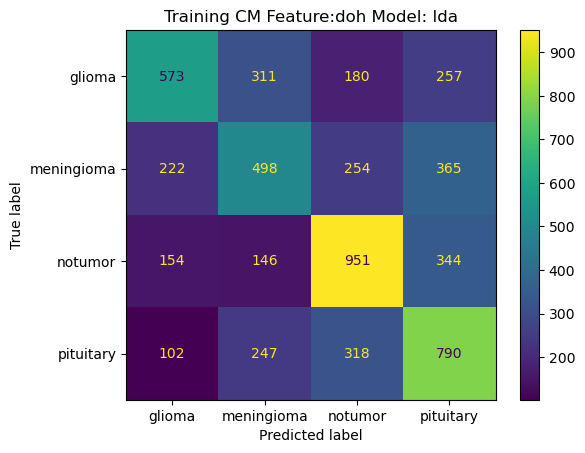

(5712, 4)


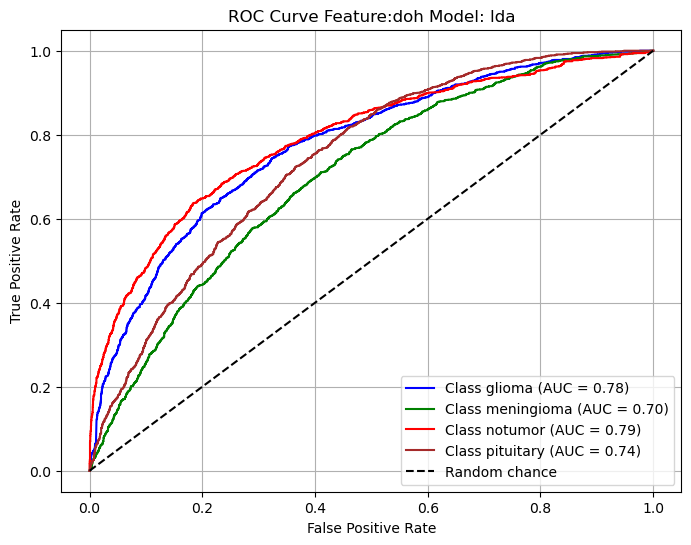

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

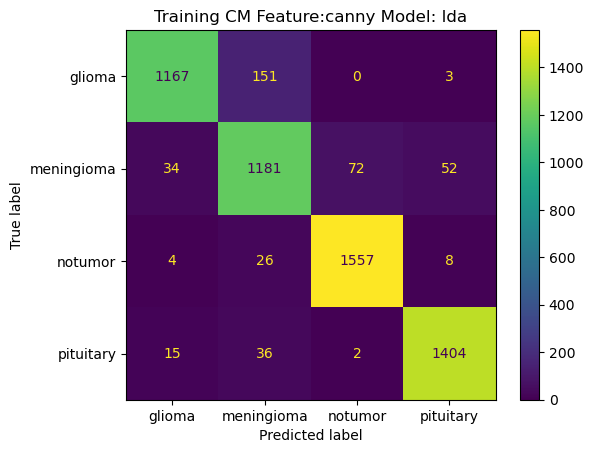

(5712, 4)


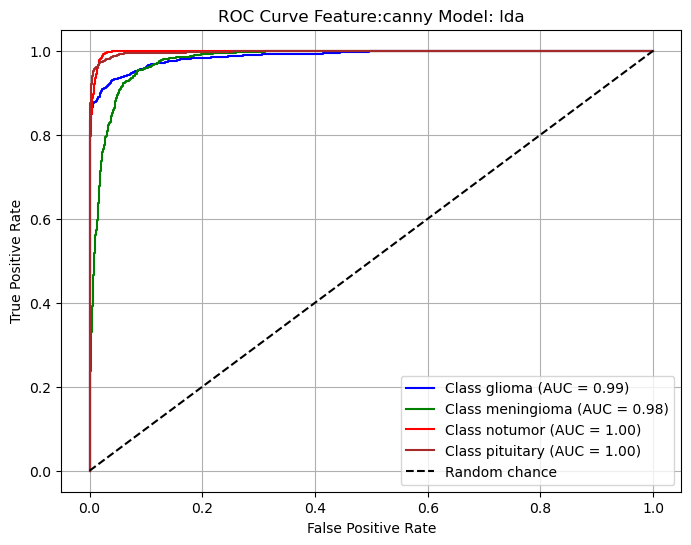

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

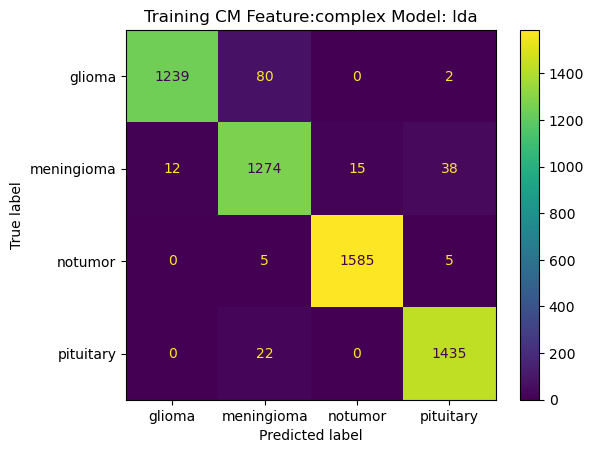

(5712, 4)


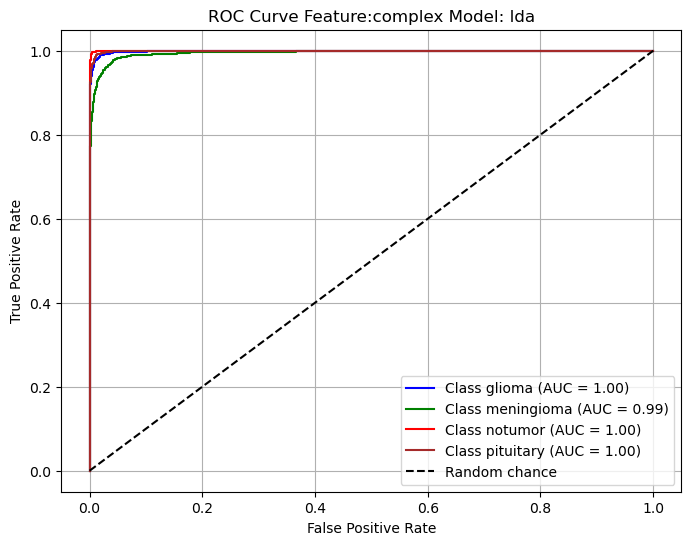

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

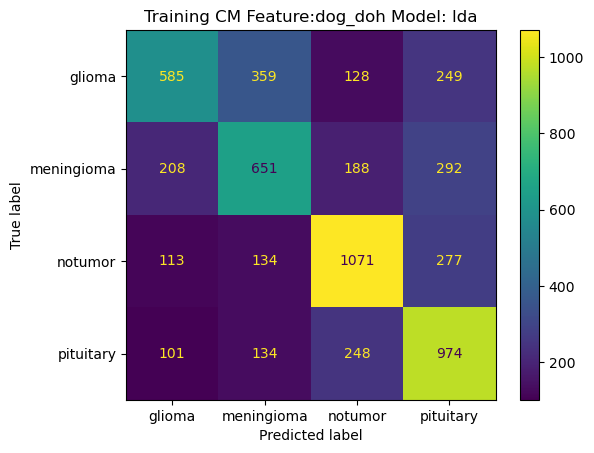

(5712, 4)


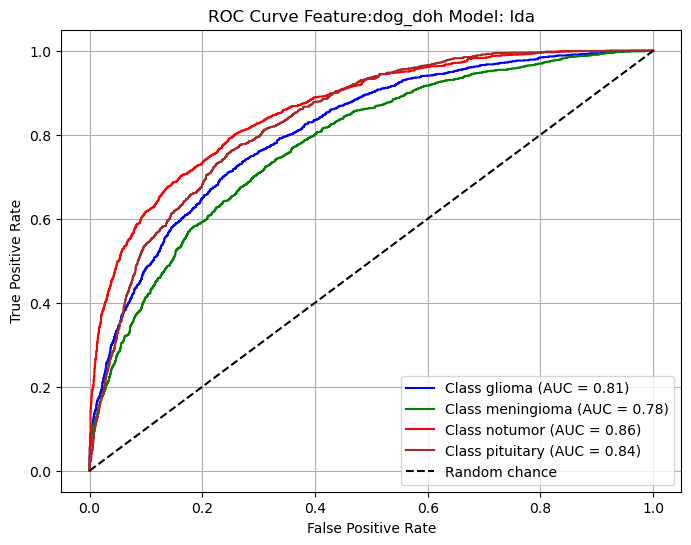

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

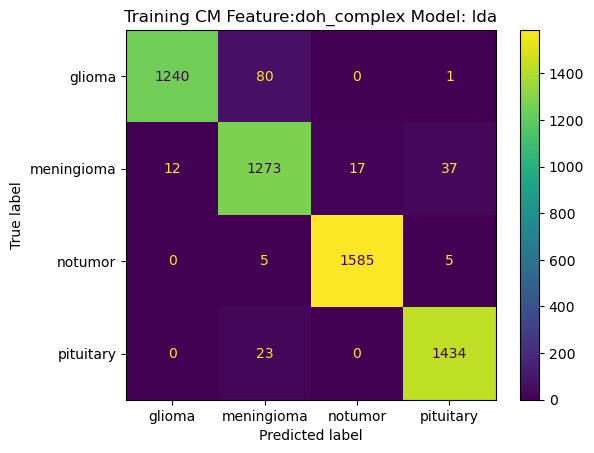

(5712, 4)


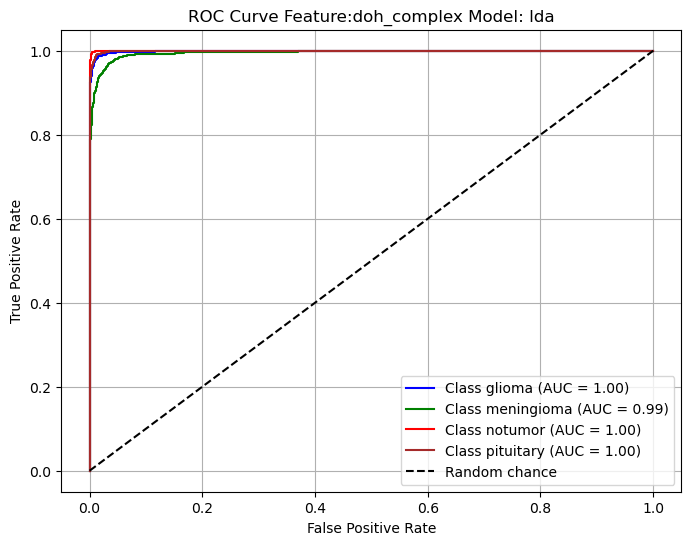

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

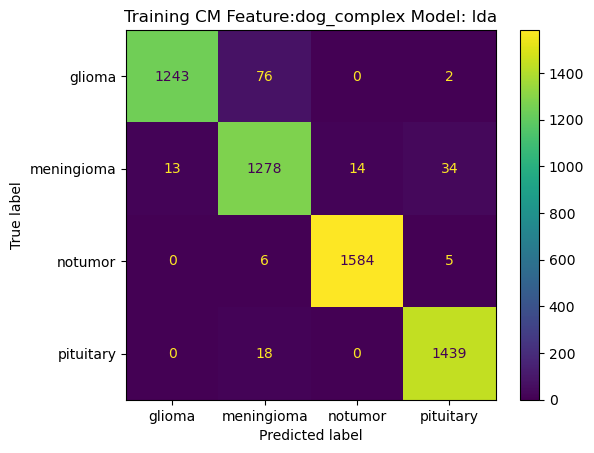

(5712, 4)


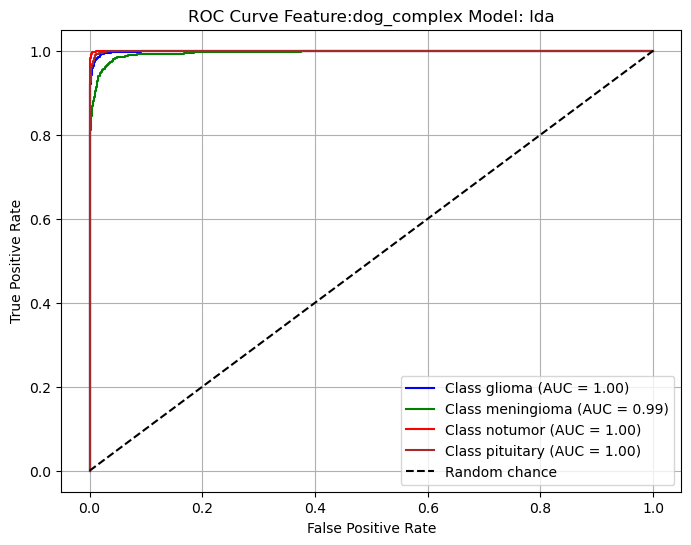

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/richardyan/mi

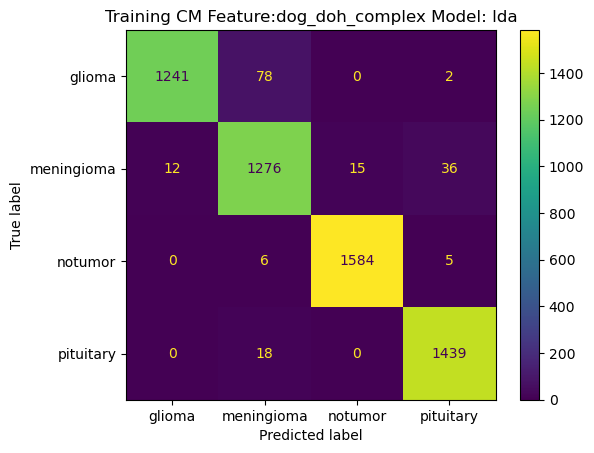

(5712, 4)


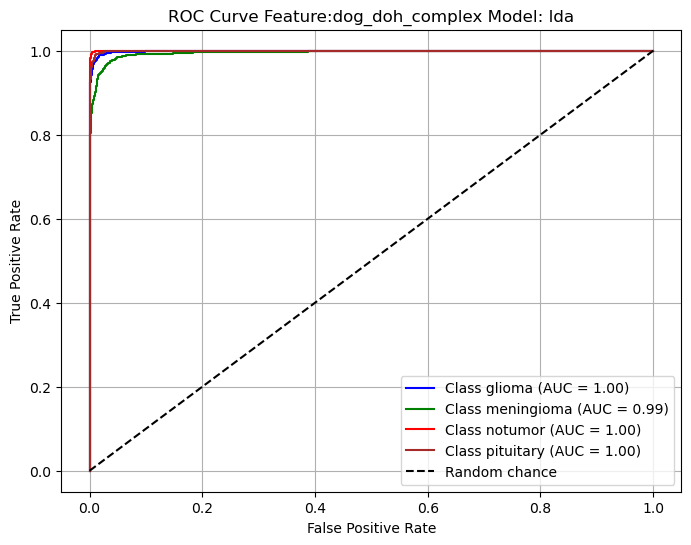

saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog to path=models/logistic_dog.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh to path=models/logistic_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_canny to path=models/logistic_canny.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_complex to path=models/logistic_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh to path=models/logistic_dog_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh_complex to path=models/logistic_doh_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_complex to path=models/logistic_dog_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh_complex to path=models/logistic_dog_doh_complex.job

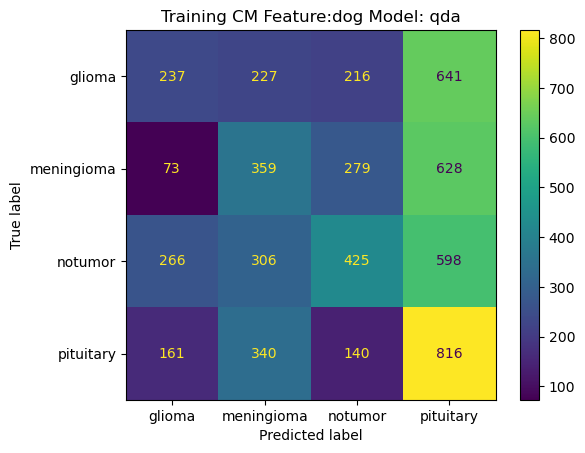

(5712, 4)


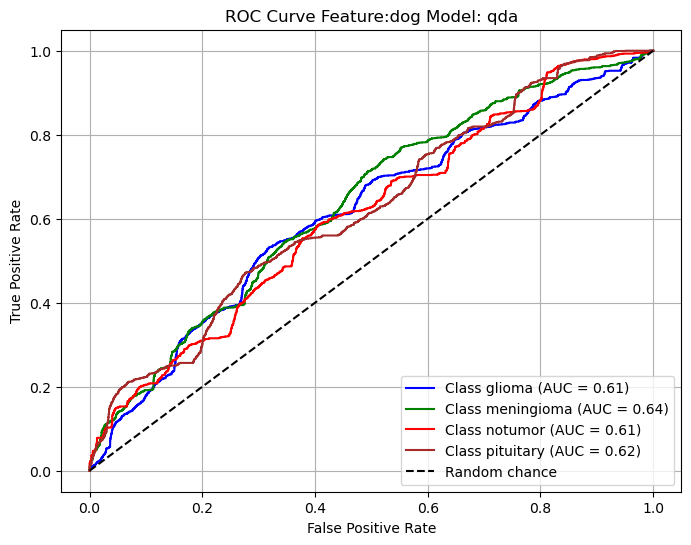

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END ......................................reg_param=1.0; total time=   0.0s
[CV] END ......................................re

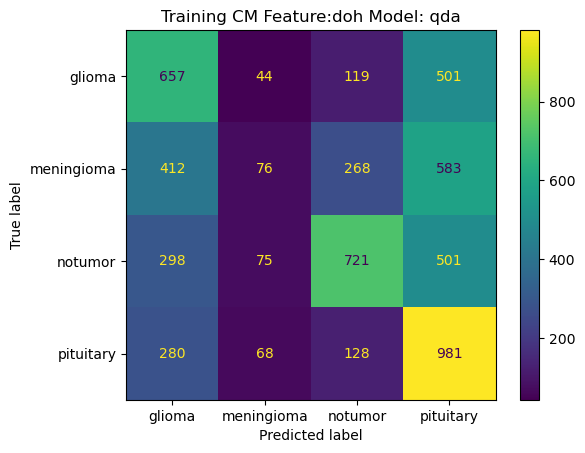

(5712, 4)


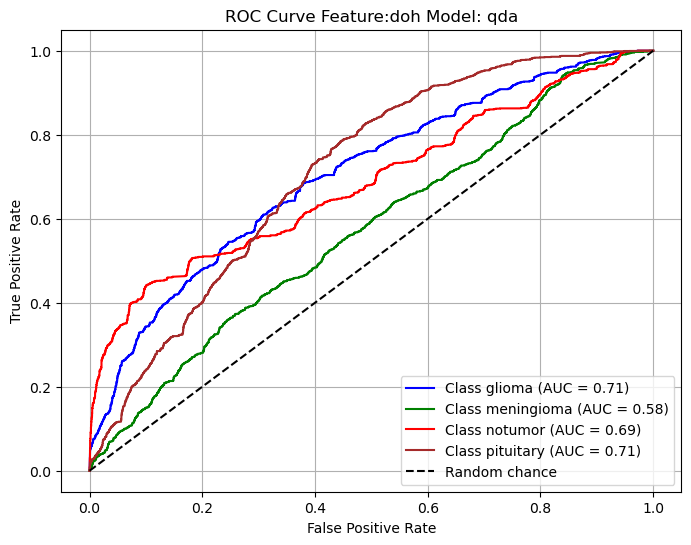

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   1.7s
[CV] END ......................................reg_param=0.5; total time=   1.7s
[CV] END ......................................reg_param=0.5; total time=   1.6s
[CV] END ......................................reg_param=0.5; total time=   1.6s
[CV] END ......................................reg_param=0.5; total time=   1.6s
[CV] END .....................................reg_param=0.75; total time=   1.6s
[CV] END .....................................reg_param=0.75; total time=   1.6s
[CV] END .....................................reg_param=0.75; total time=   1.5s
[CV] END .....................................reg_param=0.75; total time=   1.5s
[CV] END .....................................reg_param=0.75; total time=   1.6s
[CV] END ......................................reg_param=1.0; total time=   1.6s
[CV] END ......................................re

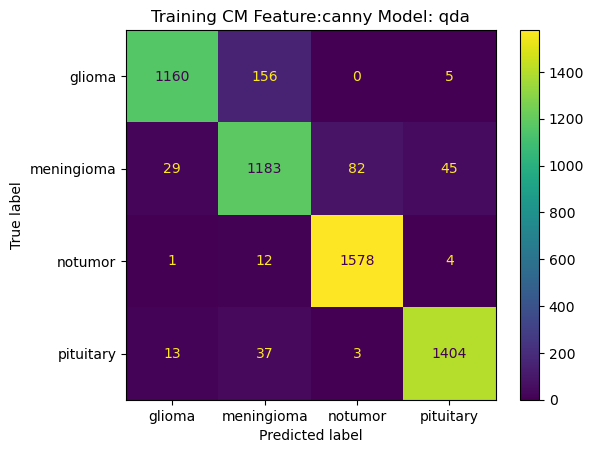

(5712, 4)


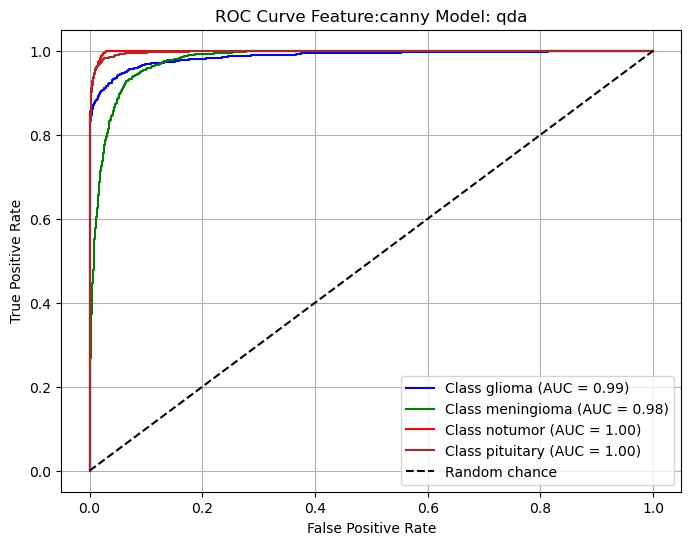

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   1.2s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END ......................................reg_param=1.0; total time=   1.1s
[CV] END ......................................re

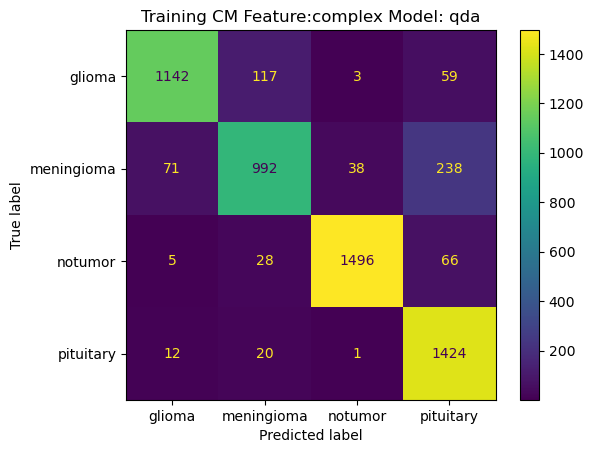

(5712, 4)


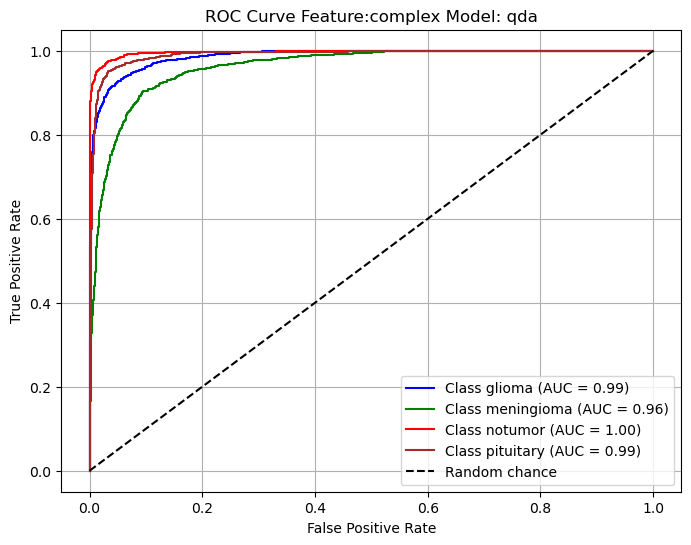

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END ......................................reg_param=1.0; total time=   0.0s
[CV] END ......................................re

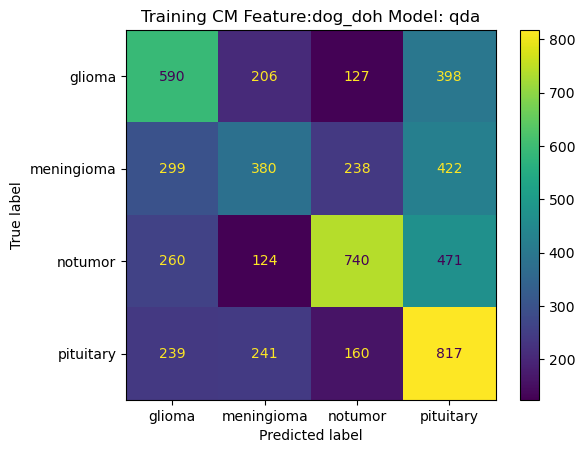

(5712, 4)


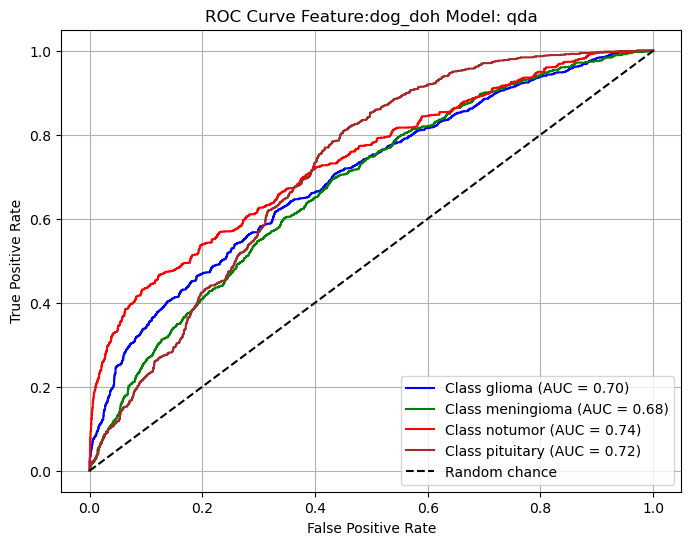

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.2s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END ......................................reg_param=1.0; total time=   1.1s
[CV] END ......................................re

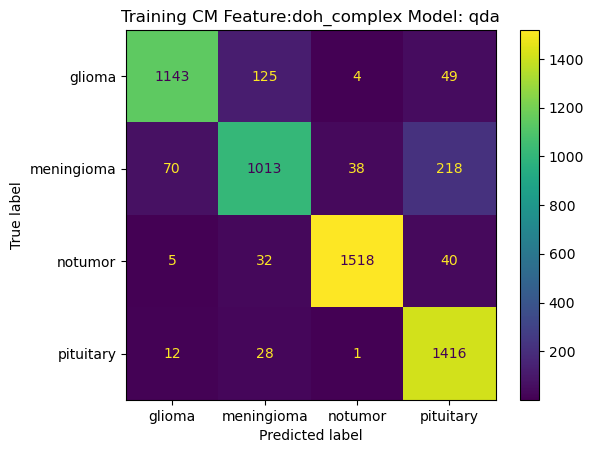

(5712, 4)


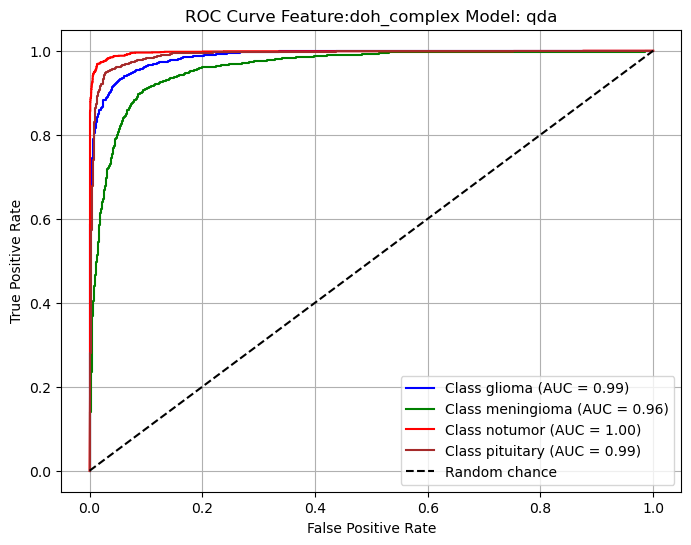

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.2s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END ......................................reg_param=1.0; total time=   1.1s
[CV] END ......................................re

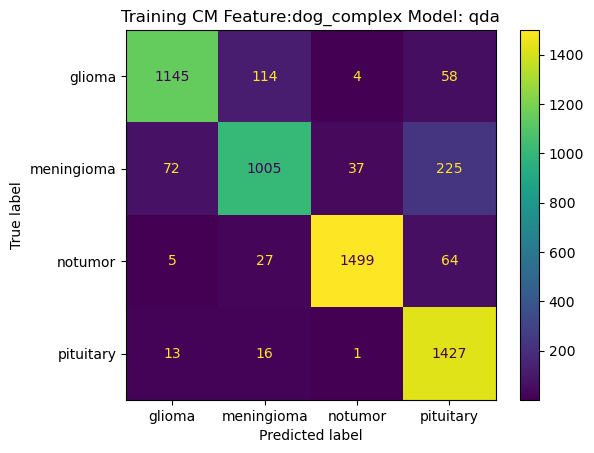

(5712, 4)


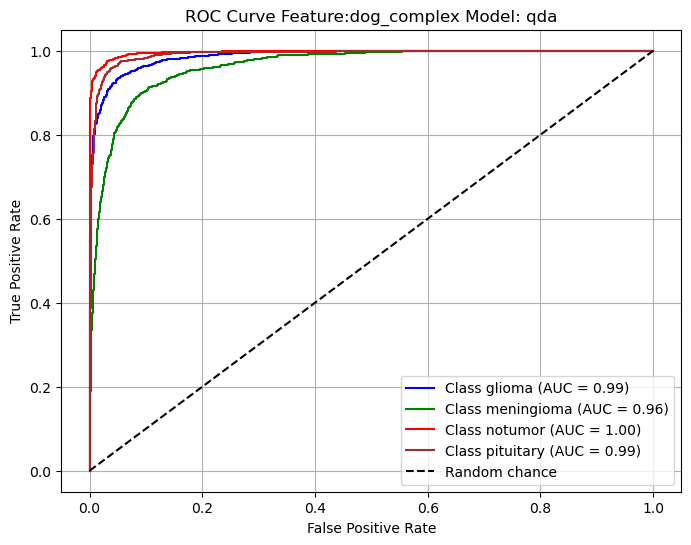

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   1.2s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.2s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END ......................................reg_param=0.5; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END .....................................reg_param=0.75; total time=   1.1s
[CV] END ......................................reg_param=1.0; total time=   1.1s
[CV] END ......................................re

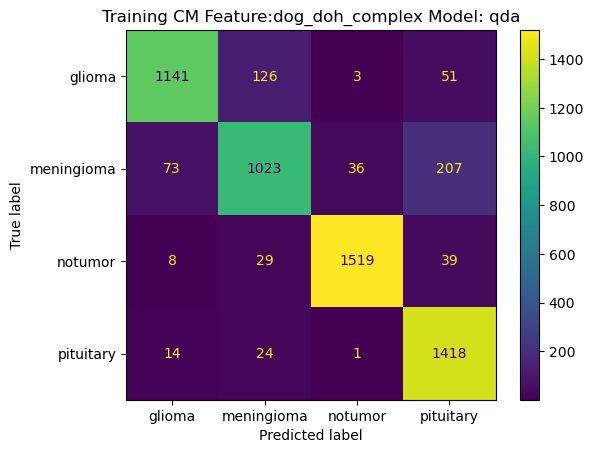

(5712, 4)


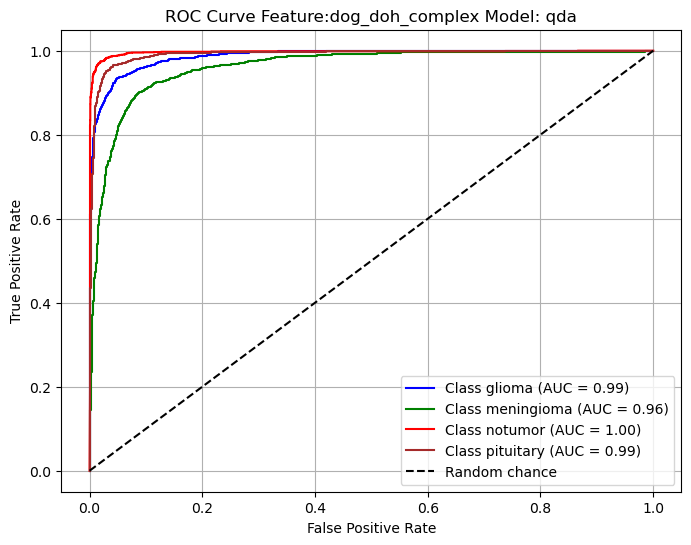

saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog to path=models/logistic_dog.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh to path=models/logistic_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_canny to path=models/logistic_canny.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_complex to path=models/logistic_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh to path=models/logistic_dog_doh.joblib
saved model=LogisticRegression(max_iter=1000) for feature=logistic_doh_complex to path=models/logistic_doh_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_complex to path=models/logistic_dog_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=logistic_dog_doh_complex to path=models/logistic_dog_doh_complex.job

In [9]:
model_types = ['logistic','svm','rf','lda','qda']

features = {'dog':X_dog_features,
            'doh':X_doh_features,
            'canny':X_canny_features,
            'complex': X_complex_features,
            'dog_doh': np.concatenate((X_dog_features, X_doh_features), axis=1),
            'doh_complex': np.concatenate((X_doh_features, X_complex_features), axis=1),
            'dog_complex': np.concatenate((X_dog_features, X_complex_features), axis=1),
            'dog_doh_complex': np.concatenate((X_dog_features, X_doh_features, X_complex_features), axis=1)
            }

all_results = pd.DataFrame(columns = ['feature', 'model_type', 'accuracy_score', 'macro_precision', 'macro_recall', 'macro_f1', 
                                      'micro_precision', 'micro_recall', 'micro_f1', 'training_time'])
model_store = {}

for model_type in model_types:
    for feature in features.keys():
        model, results = train_model(features[feature], y_train, classes=le.classes_, model_type=model_type, feature=feature)
        all_results.loc[len(all_results)] = results
        model_store[str(model_type) + "_" + str(feature)] = model
    save_models(model_store)

print(all_results)

all_results.to_csv('results/training_results.csv')

### 6. Load Models

In [10]:
model_types = ['logistic','svm','rf','lda','qda']

features = {'dog':X_dog_features,
            'doh':X_doh_features,
            'canny':X_canny_features,
            'complex': X_complex_features,
            'dog_doh': np.concatenate((X_dog_features, X_doh_features), axis=1),
            'doh_complex': np.concatenate((X_doh_features, X_complex_features), axis=1),
            'dog_complex': np.concatenate((X_dog_features, X_complex_features), axis=1),
            'dog_doh_complex': np.concatenate((X_dog_features, X_doh_features, X_complex_features), axis=1)
            }

loaded_models = {}

for model_type in model_types:
    for feature in features.keys():
        feature_model = str(model_type) + "_" + str(feature)
        try:
            loaded_models[feature_model] = joblib.load("models//" + str(feature_model) + ".joblib")
        except:
            print("Could not load " + str(feature_model))



In [14]:
print(loaded_models.keys())

dict_keys(['logistic_dog', 'logistic_doh', 'logistic_canny', 'logistic_complex', 'logistic_dog_doh', 'logistic_doh_complex', 'logistic_dog_complex', 'logistic_dog_doh_complex', 'svm_dog', 'svm_doh', 'svm_canny', 'svm_complex', 'svm_dog_doh', 'svm_doh_complex', 'svm_dog_complex', 'svm_dog_doh_complex', 'rf_dog', 'rf_doh', 'rf_canny', 'rf_complex', 'rf_dog_doh', 'rf_doh_complex', 'rf_dog_complex', 'rf_dog_doh_complex', 'lda_dog', 'lda_doh', 'lda_canny', 'lda_complex', 'lda_dog_doh', 'lda_doh_complex', 'lda_dog_complex', 'lda_dog_doh_complex', 'qda_dog', 'qda_doh', 'qda_canny', 'qda_complex', 'qda_dog_doh', 'qda_doh_complex', 'qda_dog_complex', 'qda_dog_doh_complex'])


### 7. Ensemble Method

### 8. Final Test Evaluation

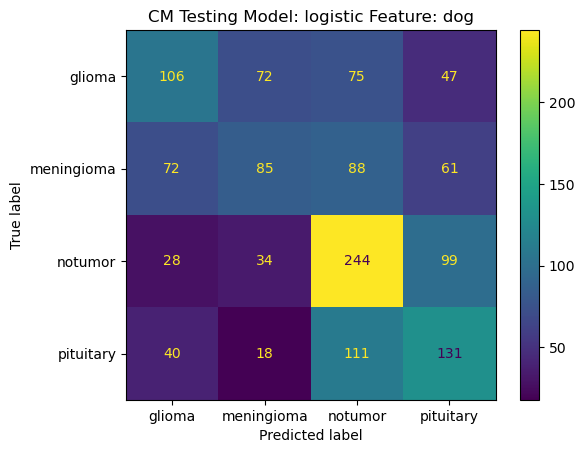

(1311, 4)


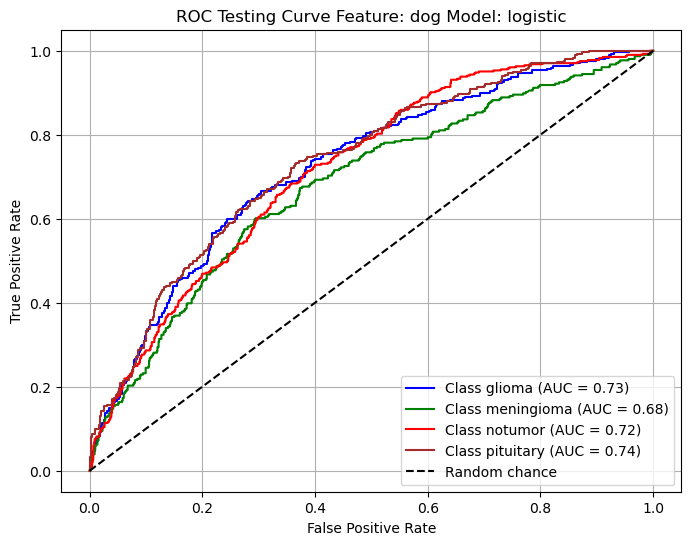

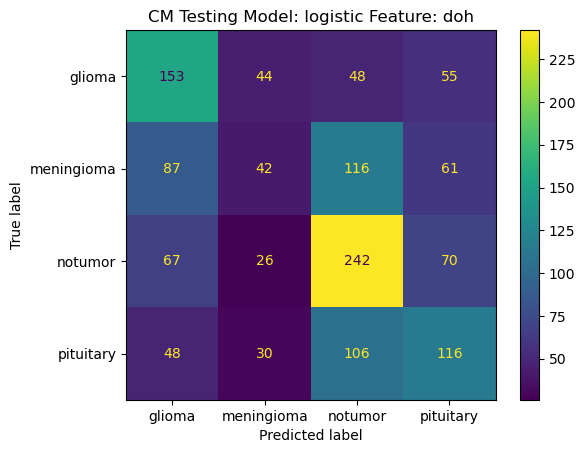

(1311, 4)


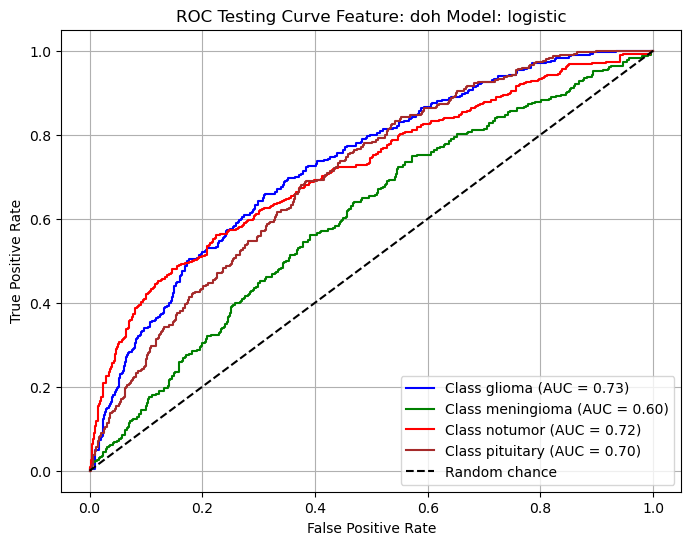

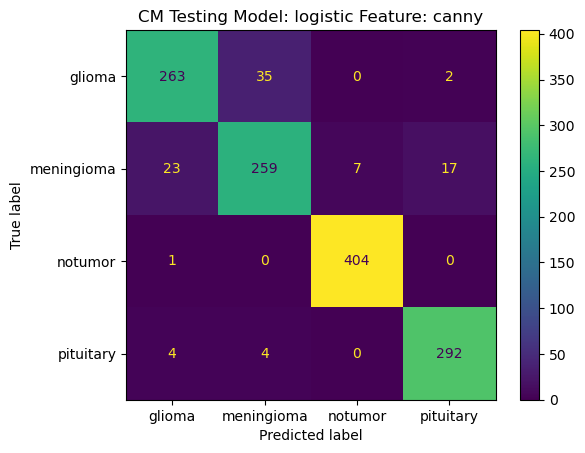

(1311, 4)


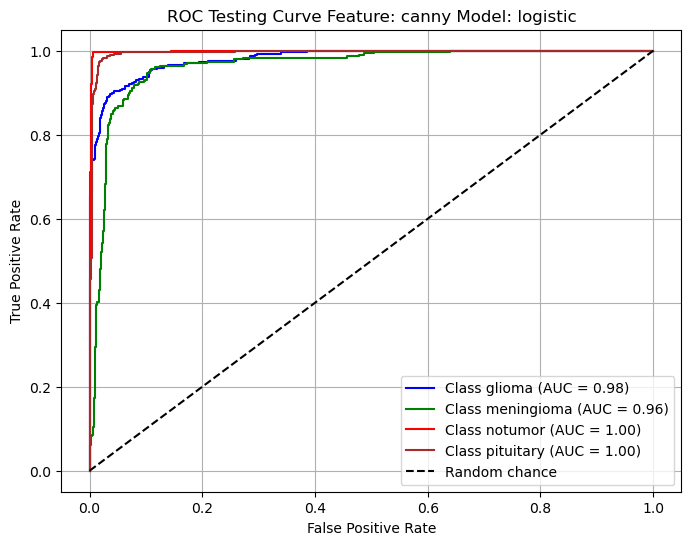

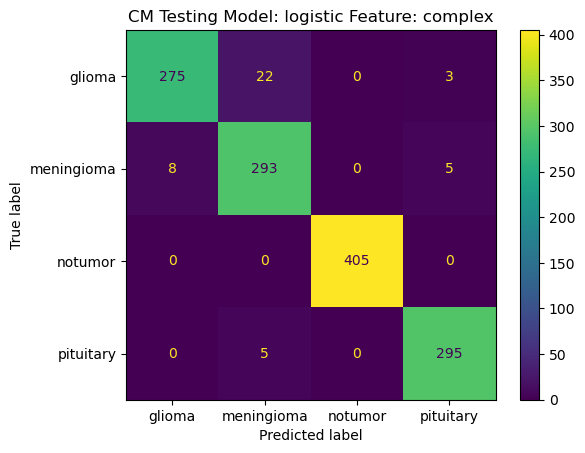

(1311, 4)


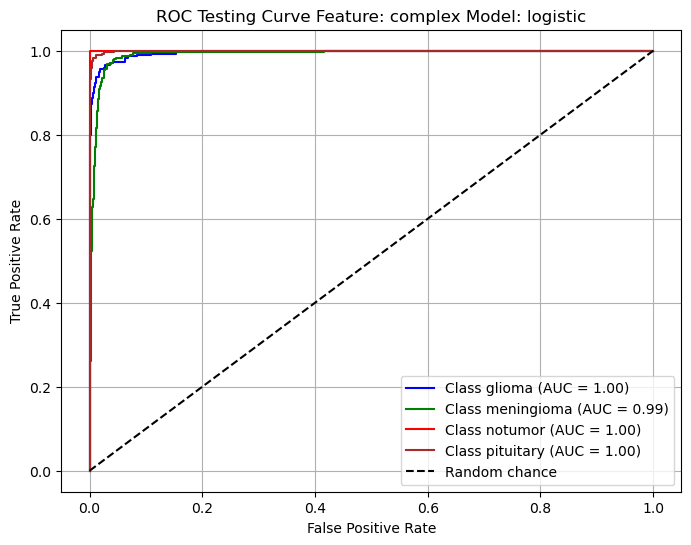

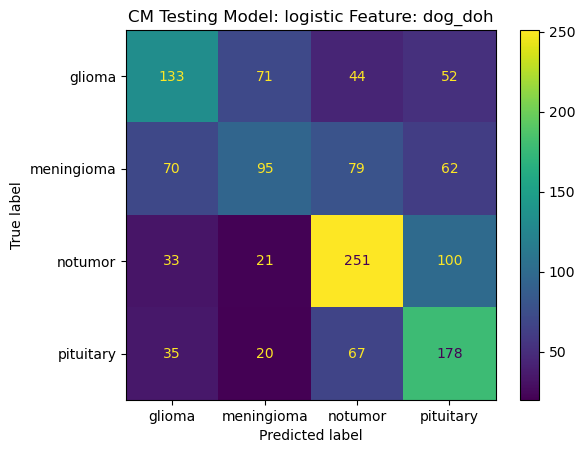

(1311, 4)


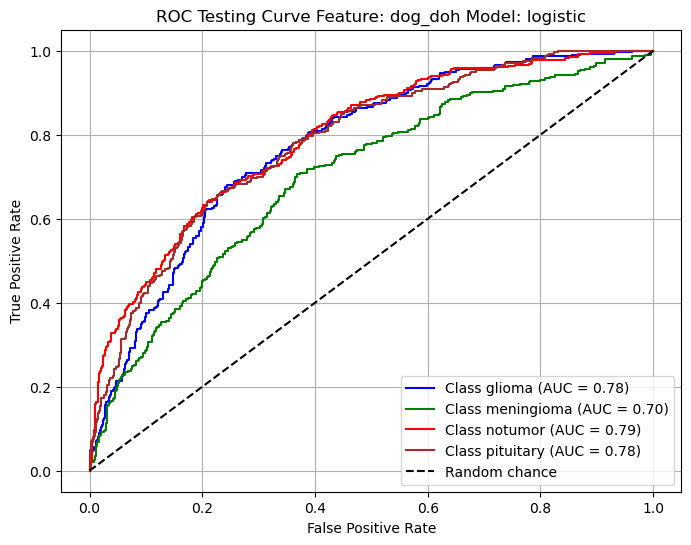

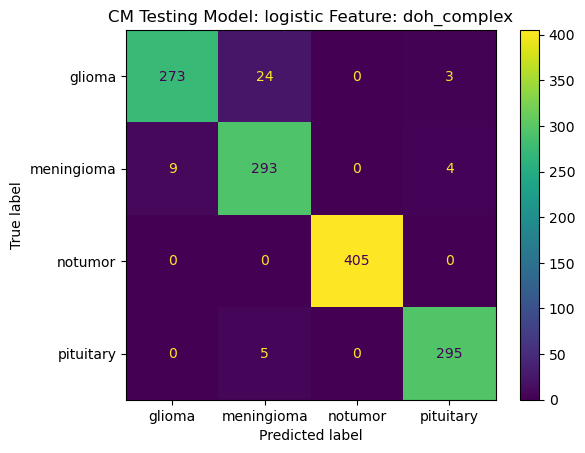

(1311, 4)


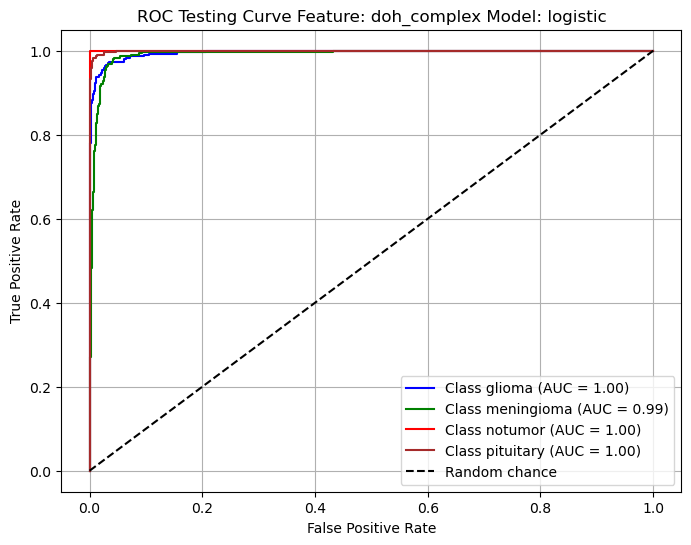

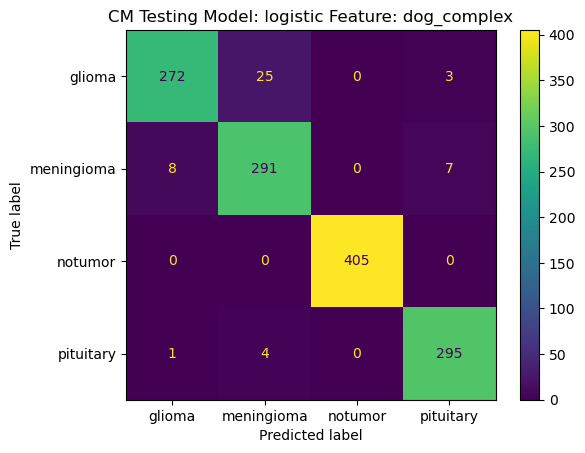

(1311, 4)


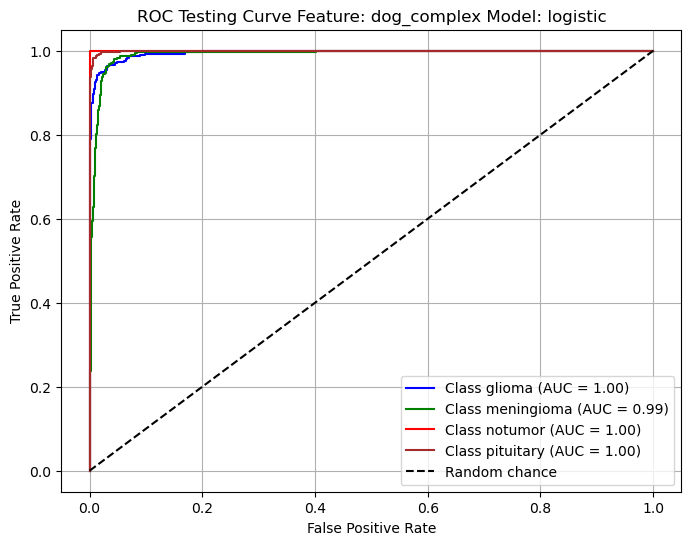

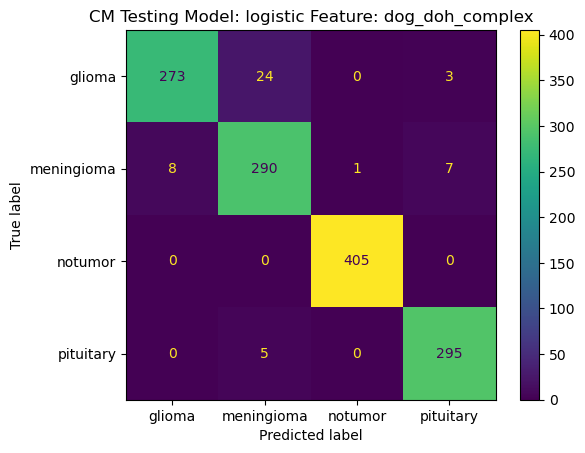

(1311, 4)


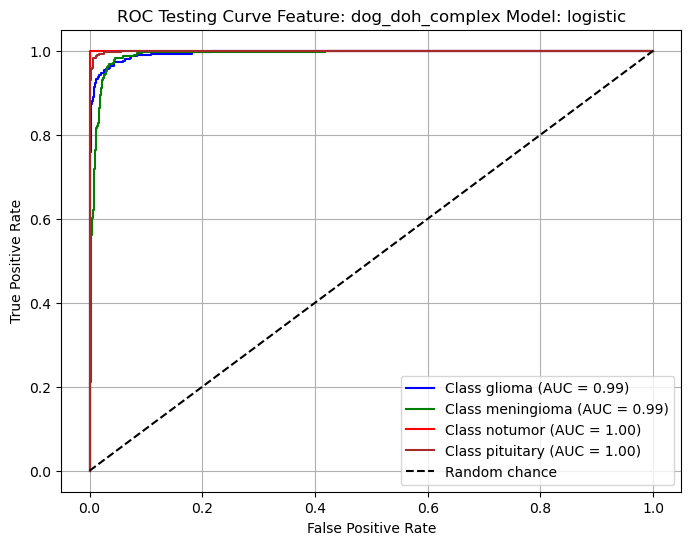

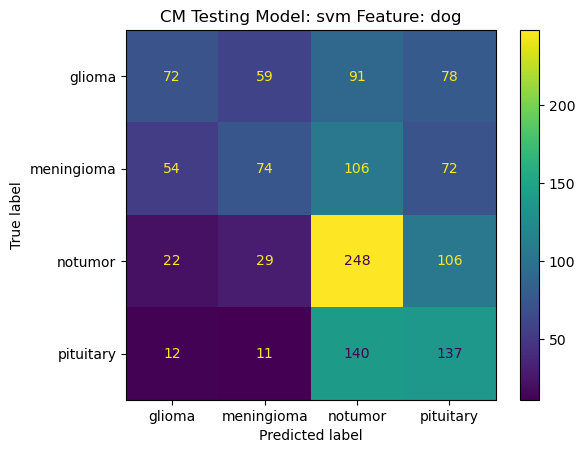

(1311, 4)


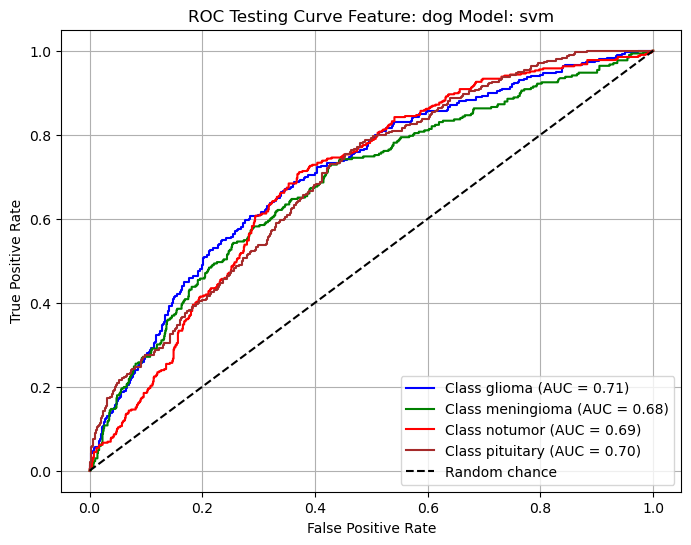

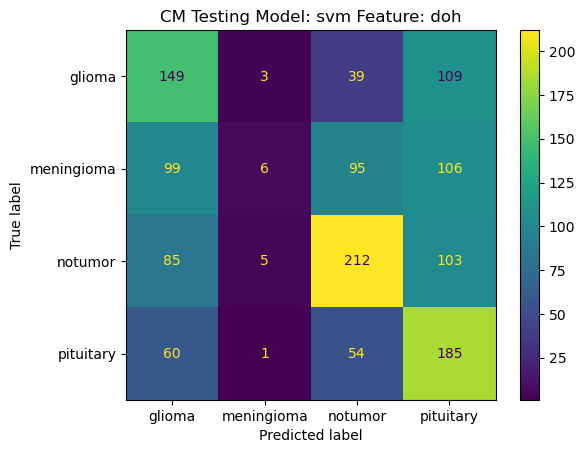

(1311, 4)


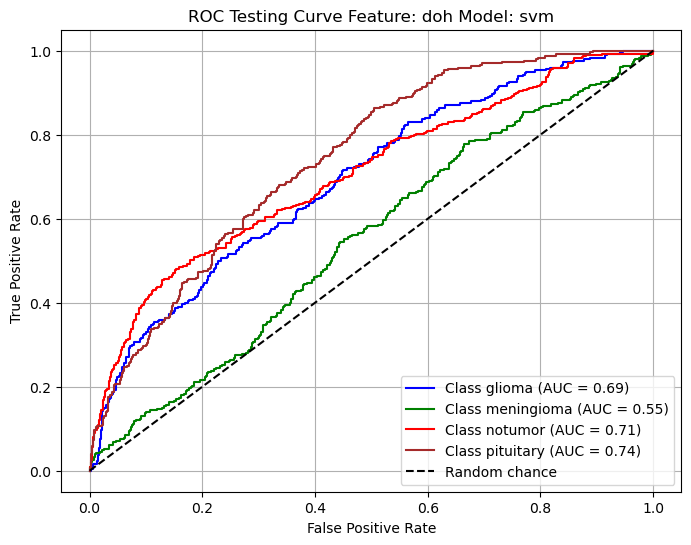

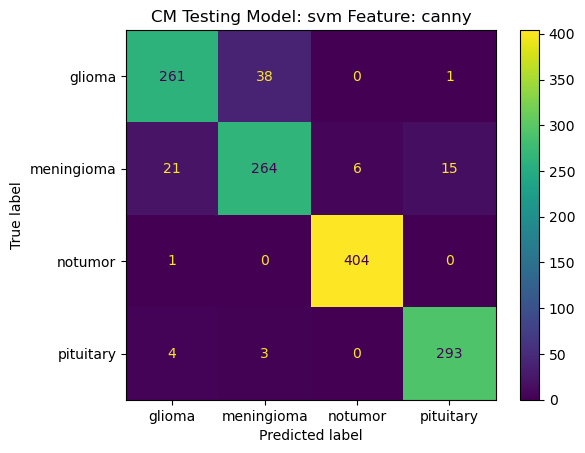

(1311, 4)


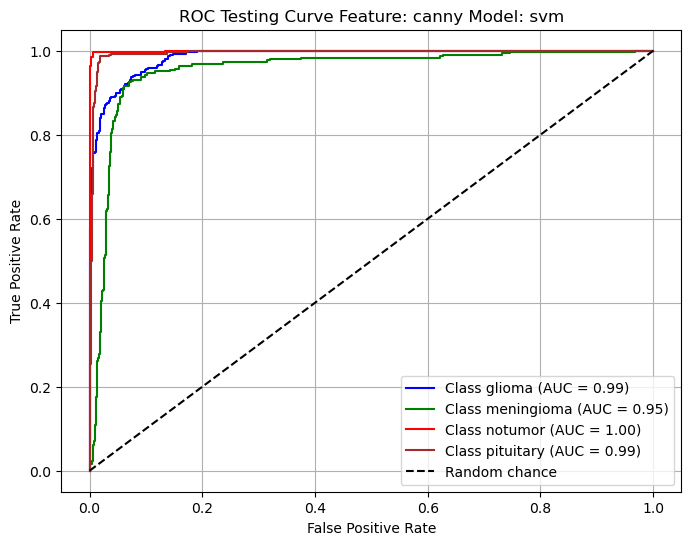

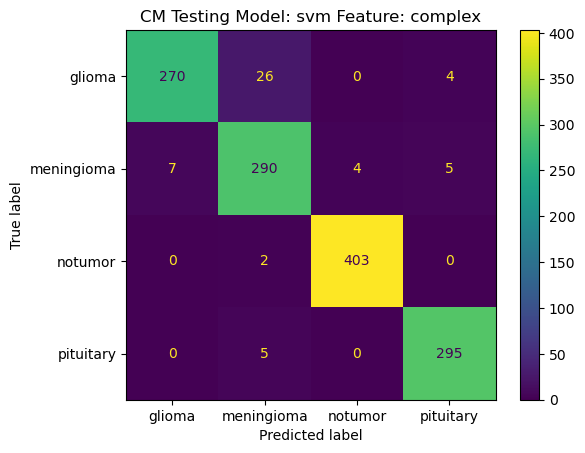

(1311, 4)


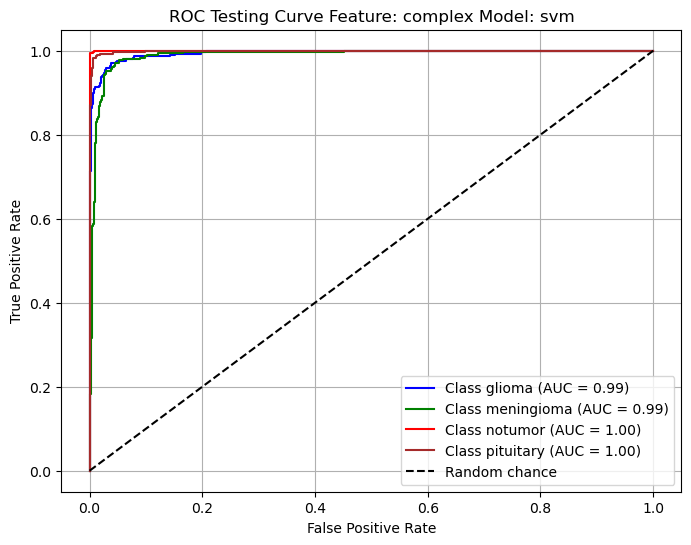

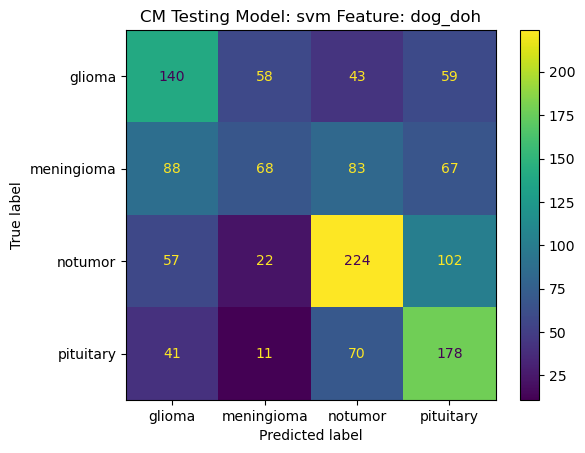

(1311, 4)


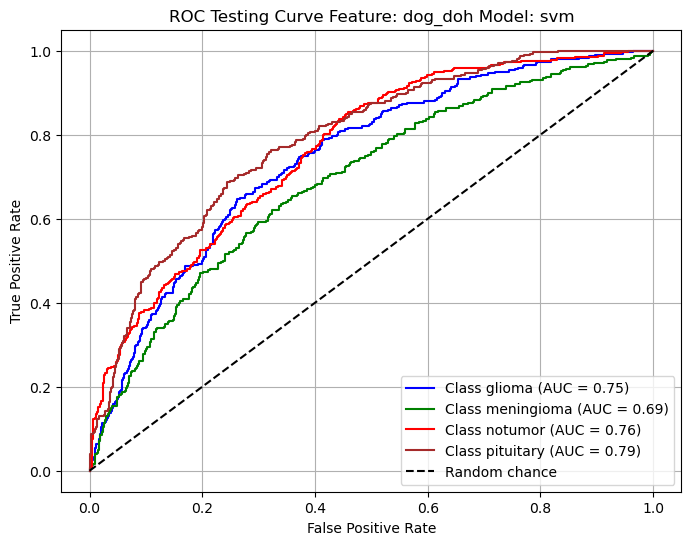

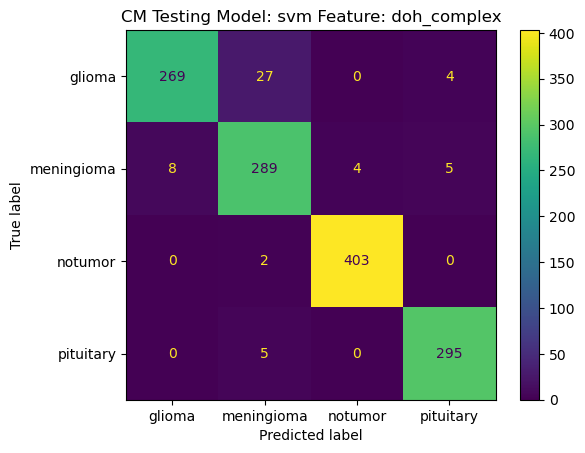

(1311, 4)


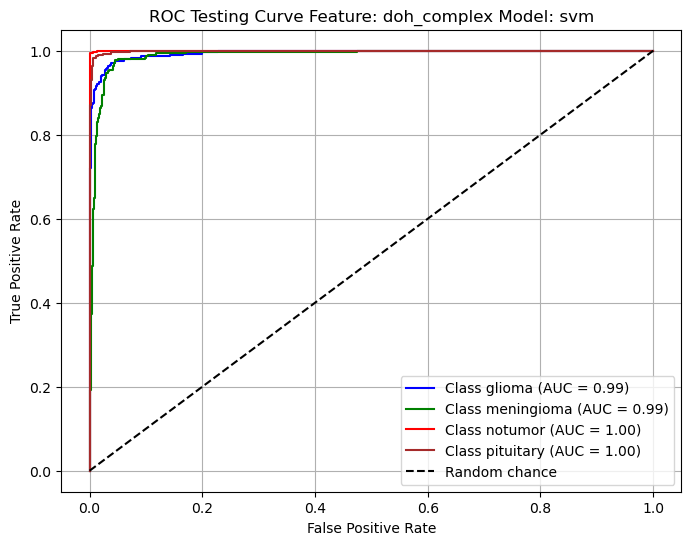

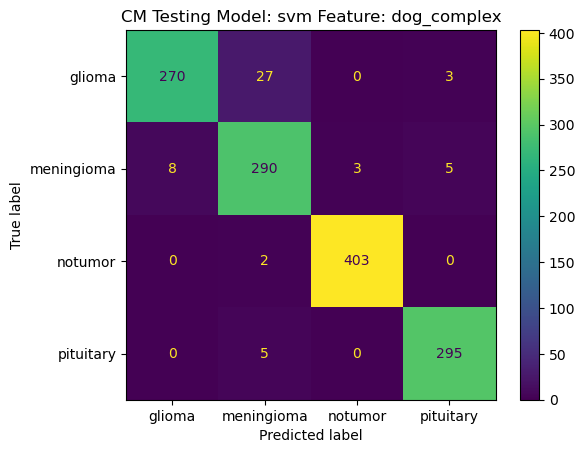

(1311, 4)


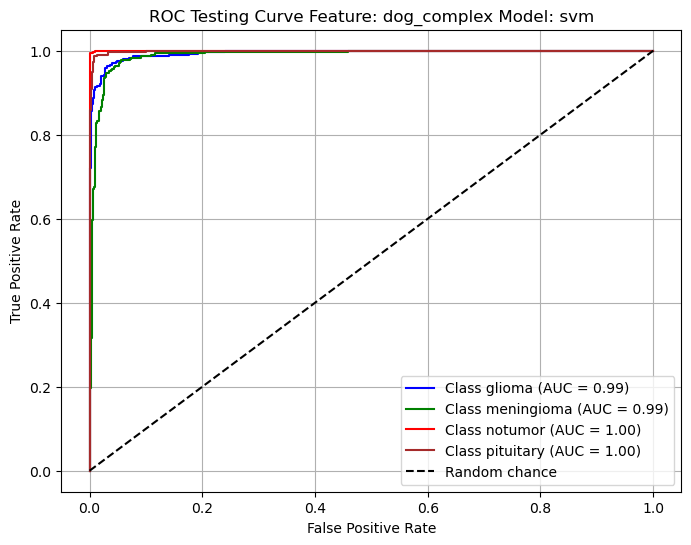

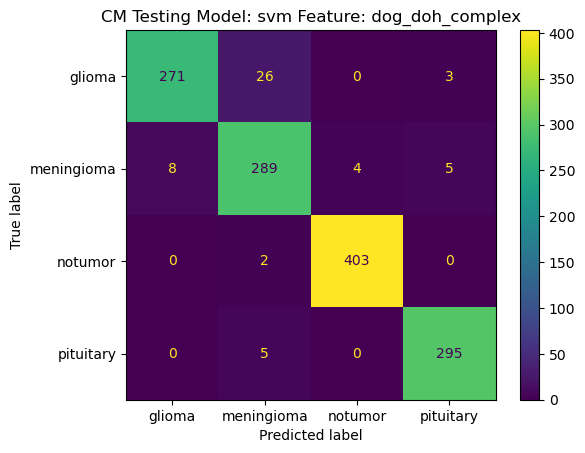

(1311, 4)


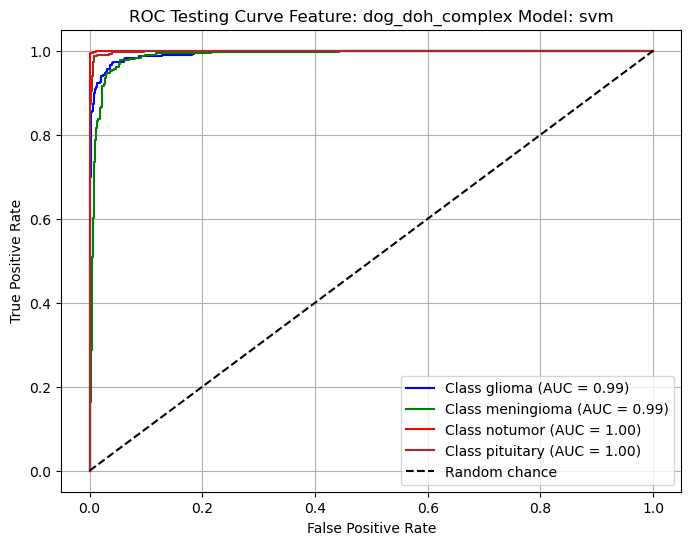

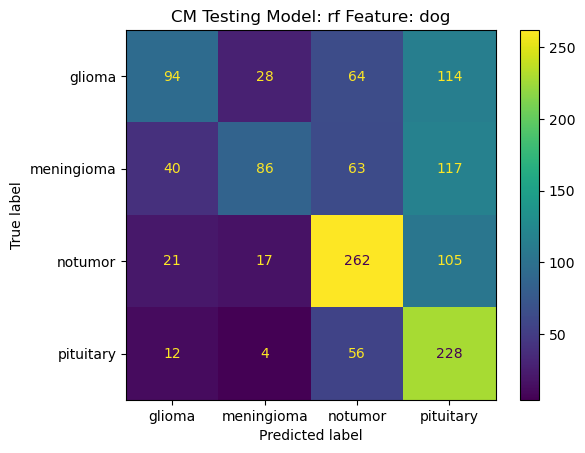

(1311, 4)


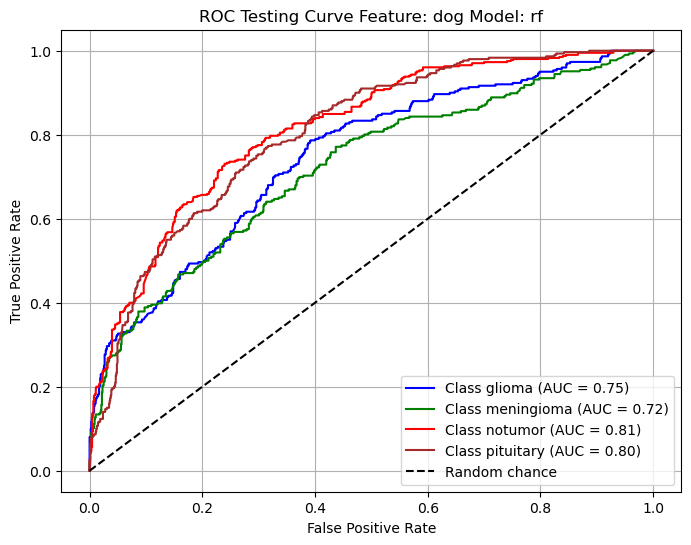

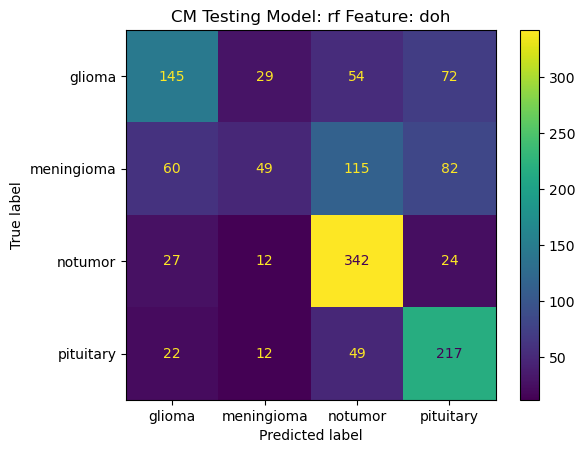

(1311, 4)


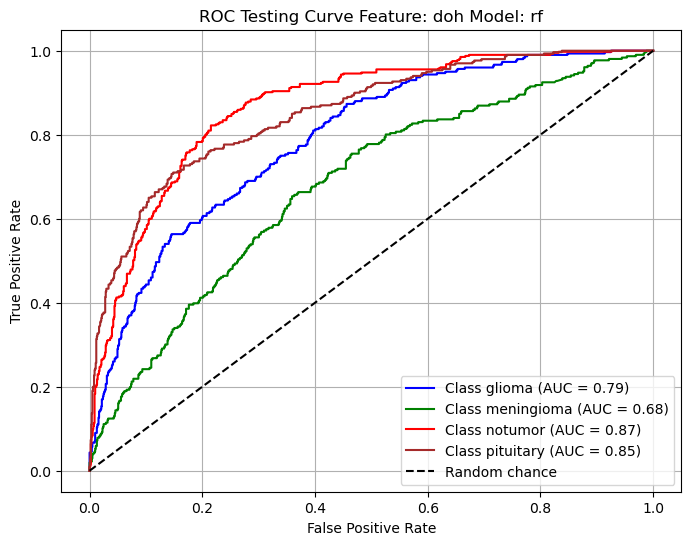

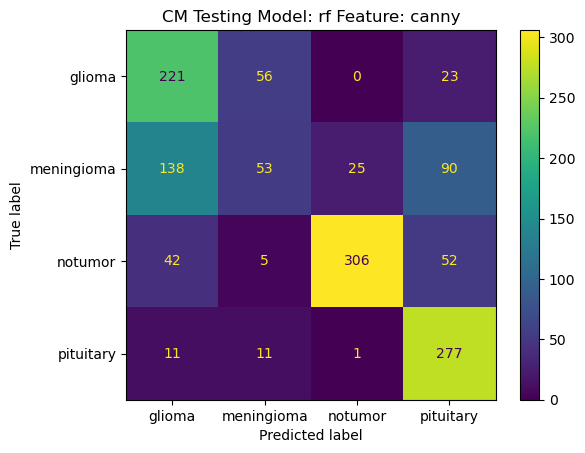

(1311, 4)


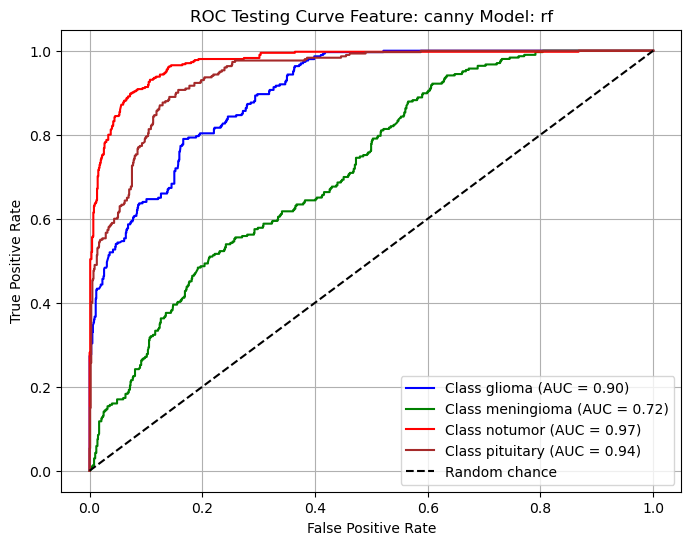

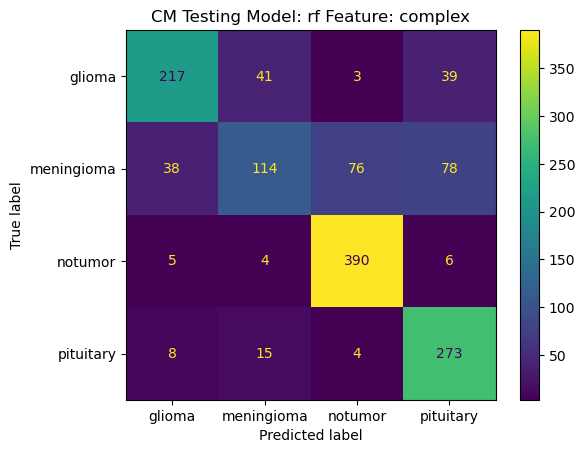

(1311, 4)


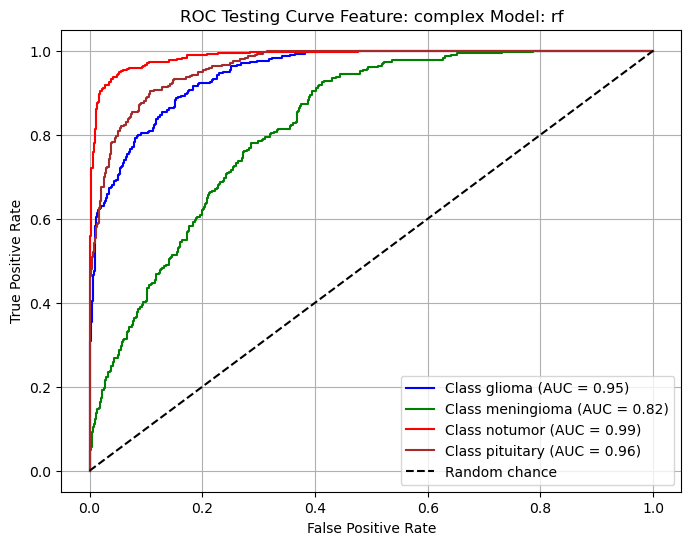

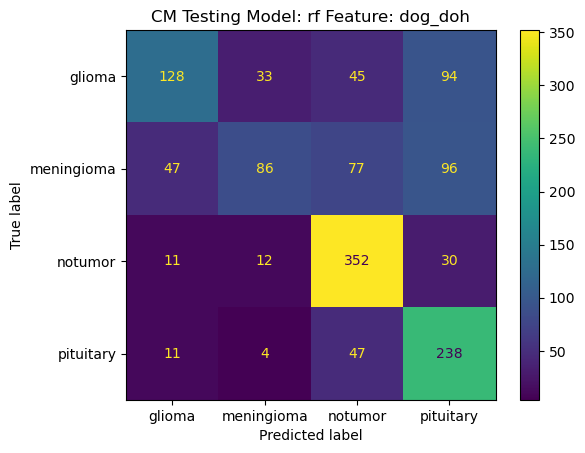

(1311, 4)


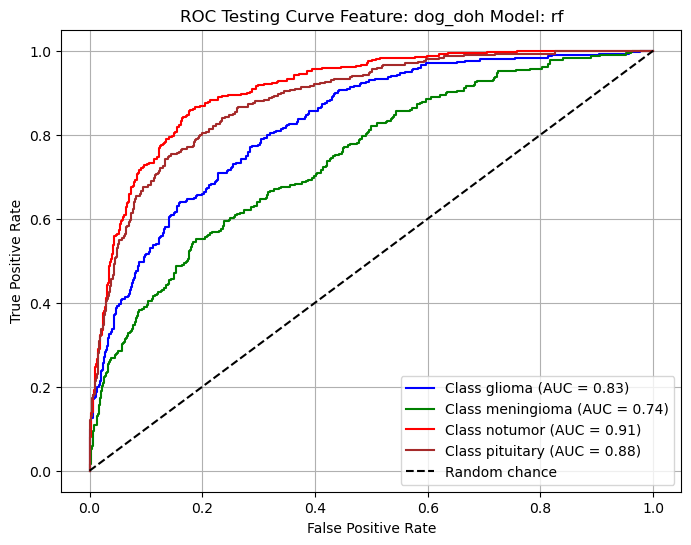

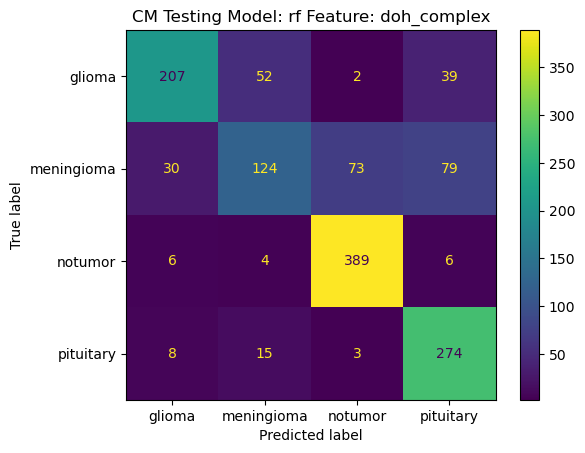

(1311, 4)


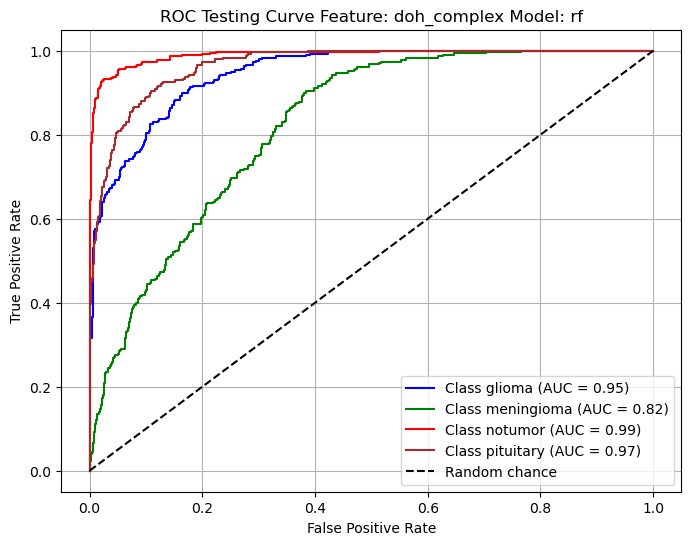

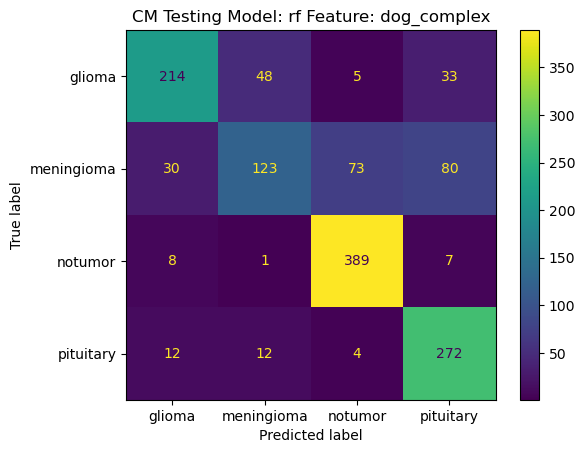

(1311, 4)


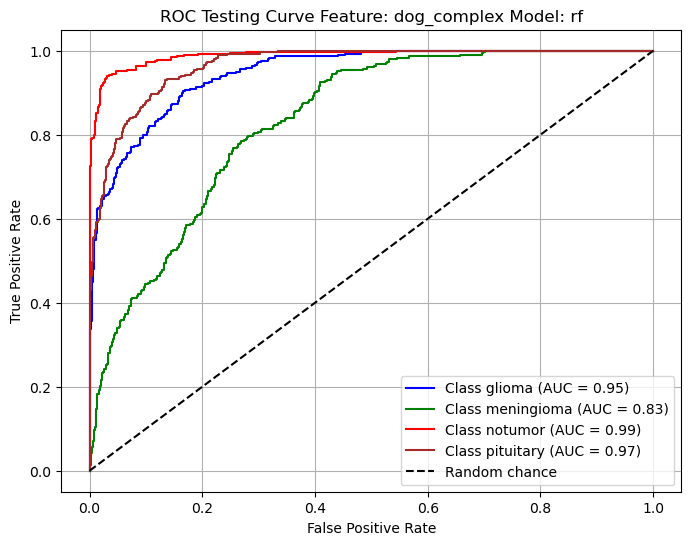

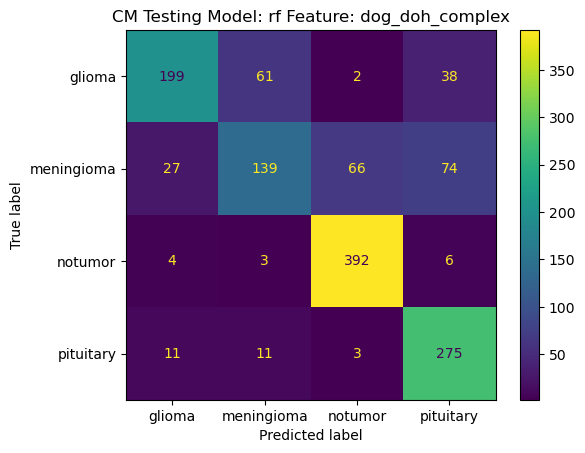

(1311, 4)


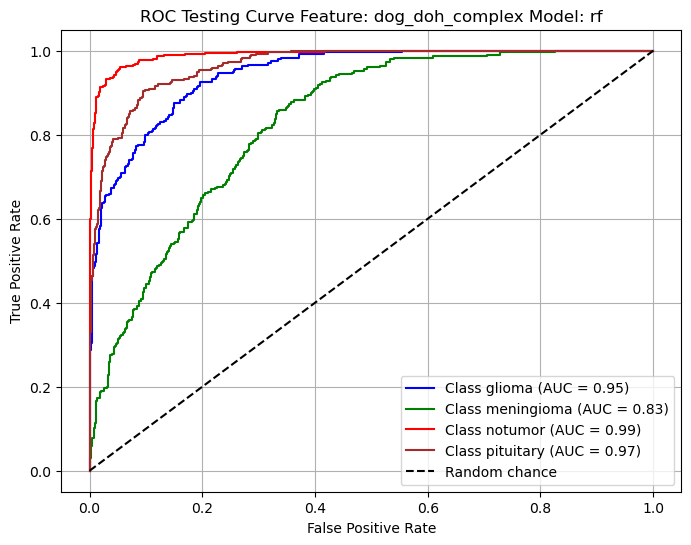

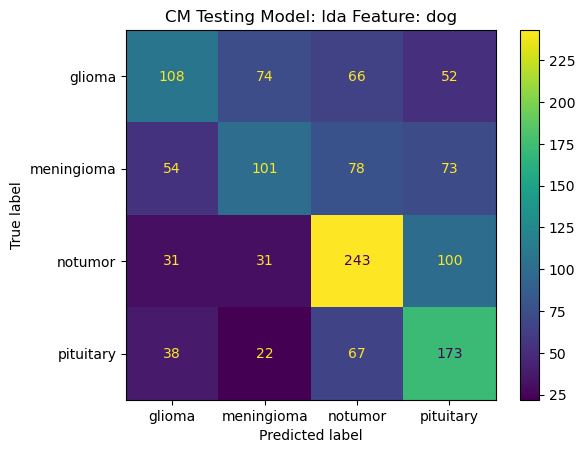

(1311, 4)


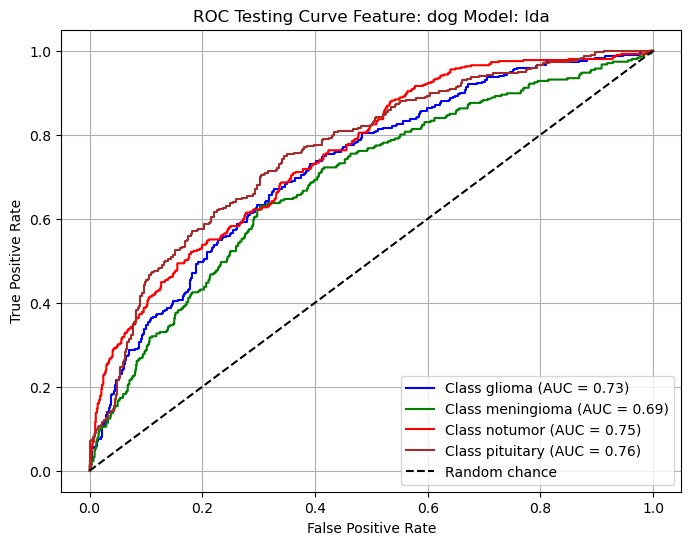

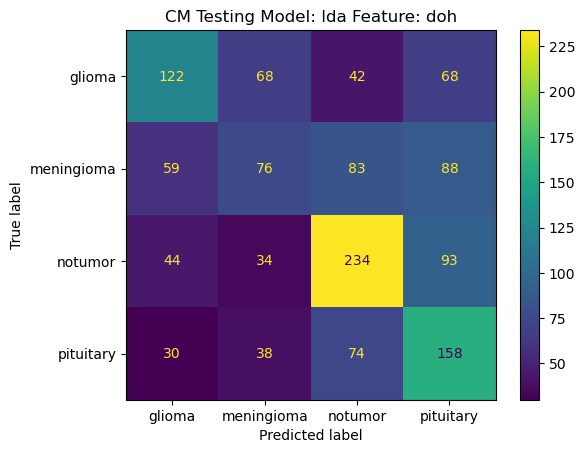

(1311, 4)


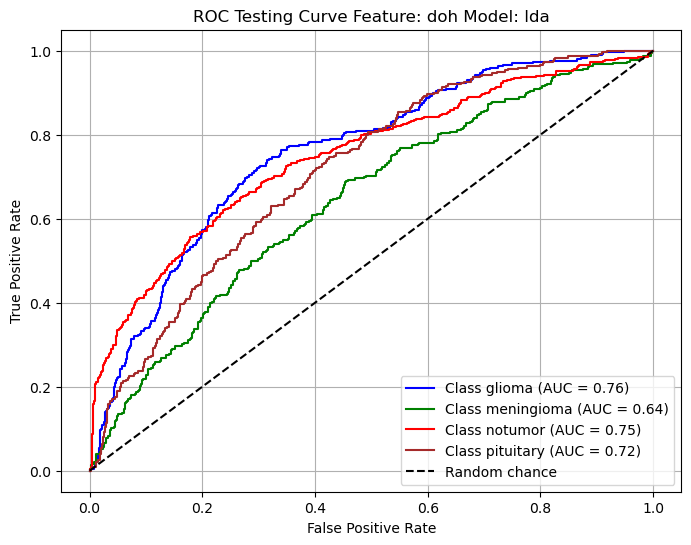

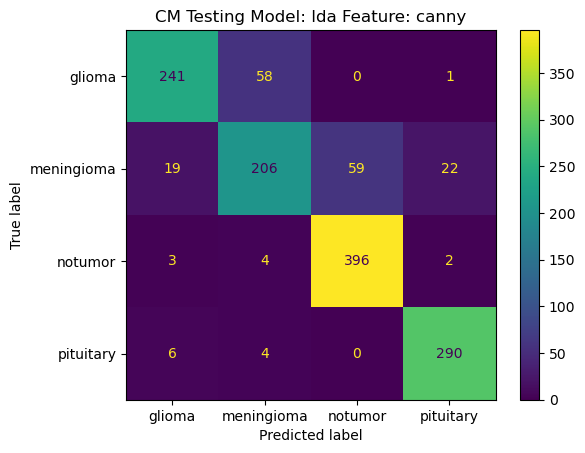

(1311, 4)


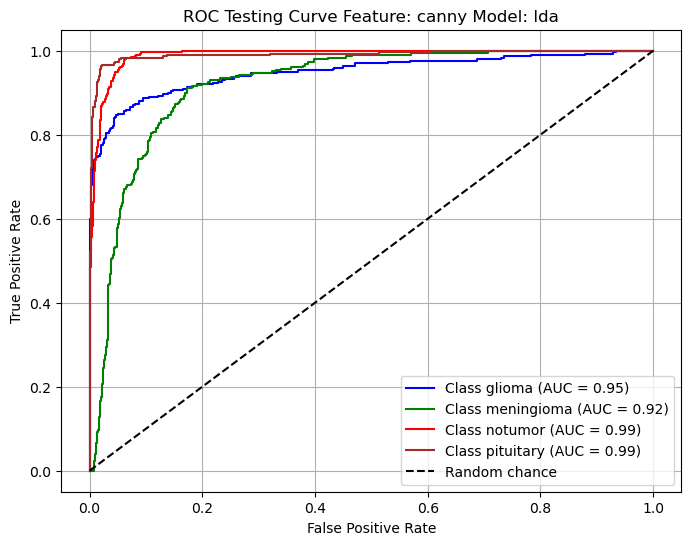

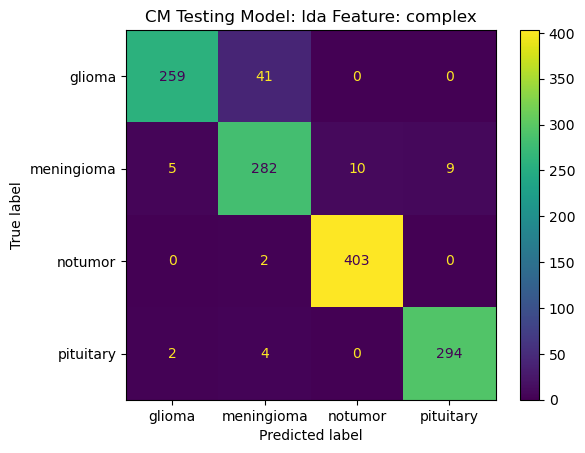

(1311, 4)


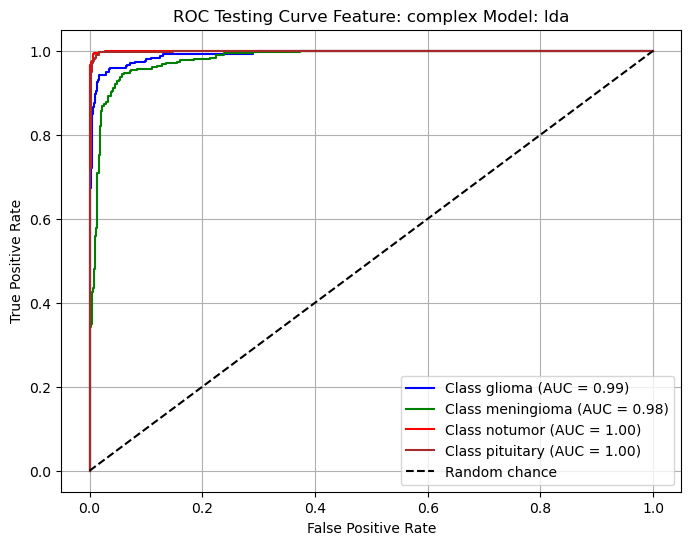

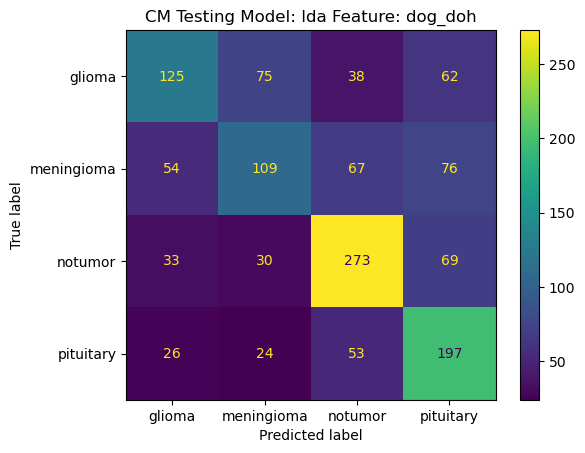

(1311, 4)


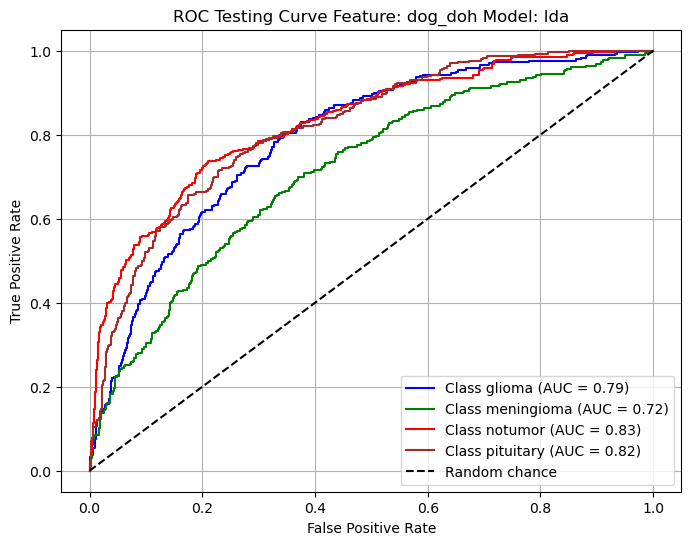

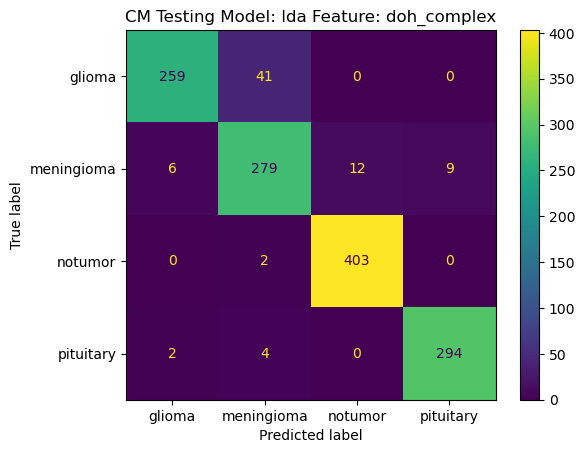

(1311, 4)


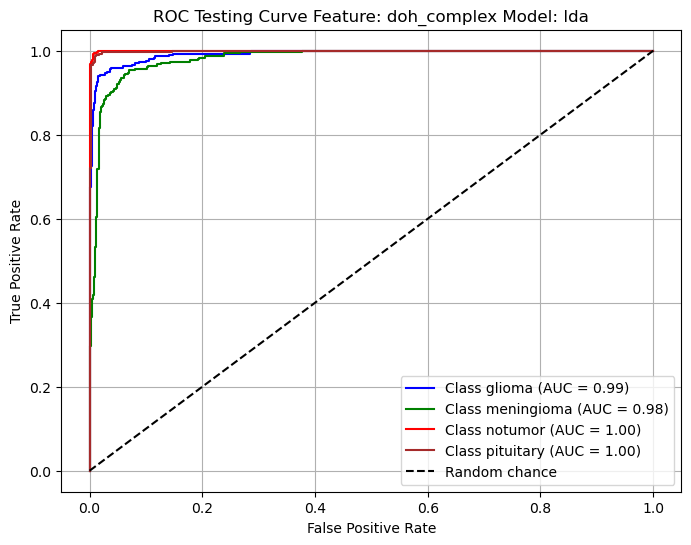

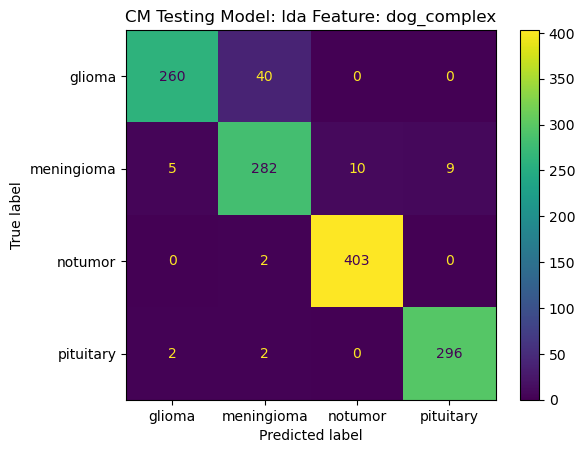

(1311, 4)


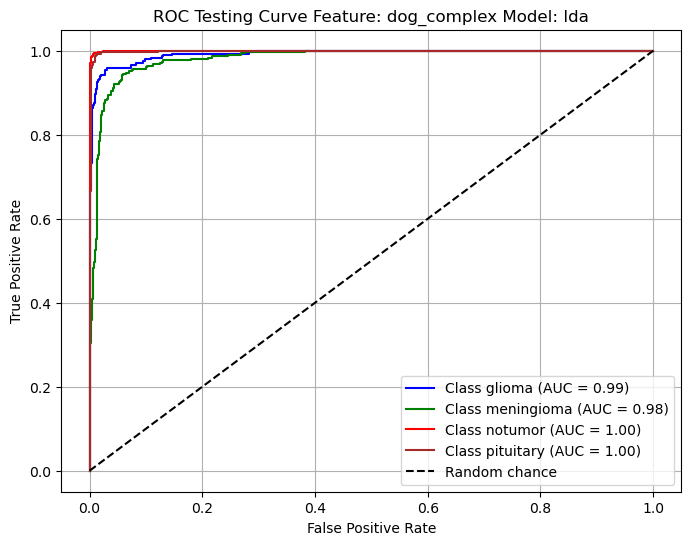

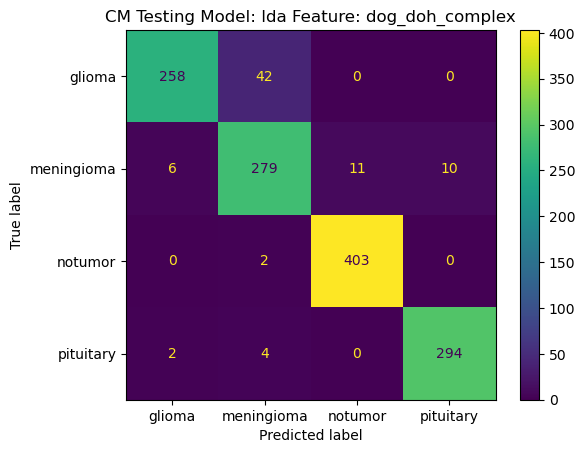

(1311, 4)


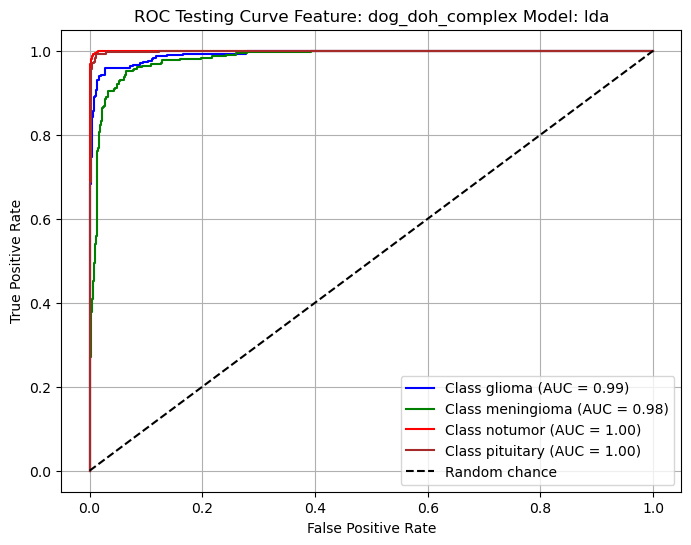

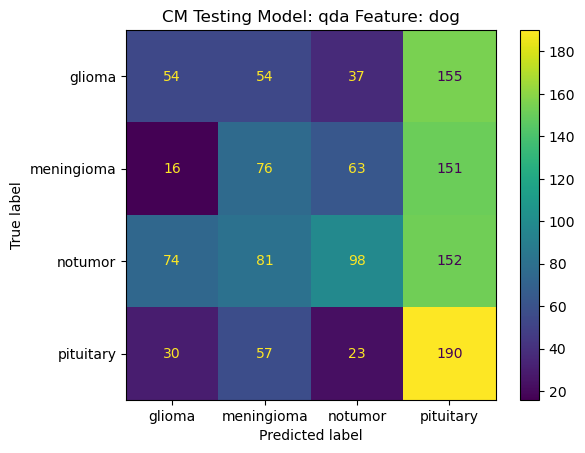

(1311, 4)


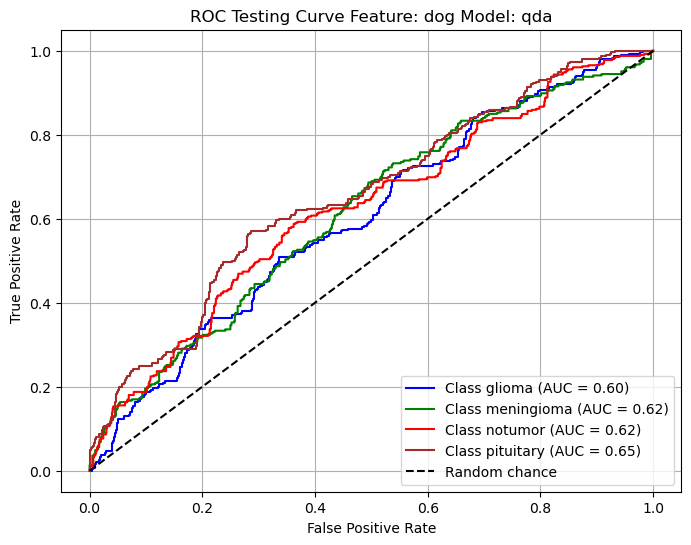

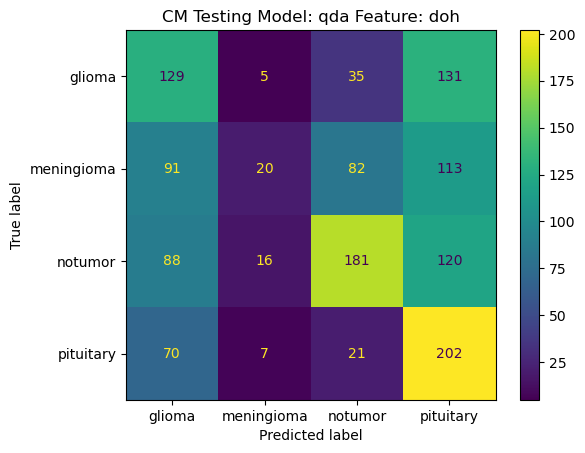

(1311, 4)


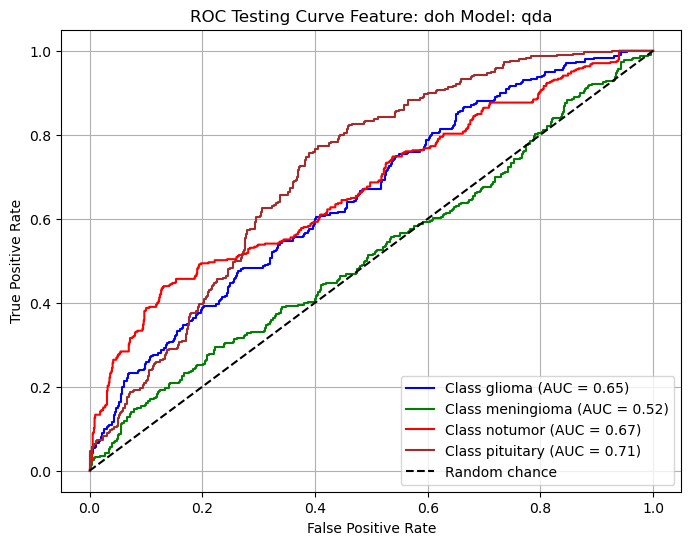

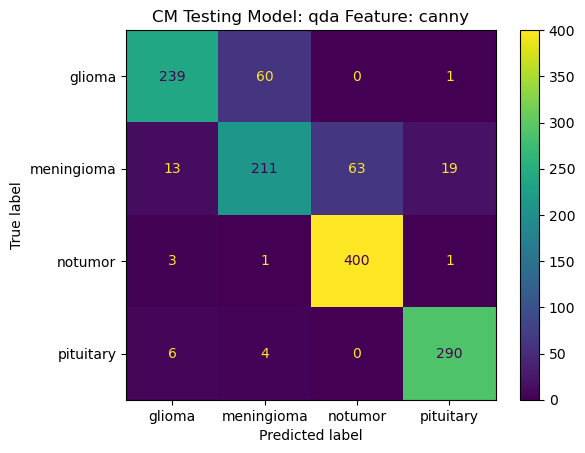

(1311, 4)


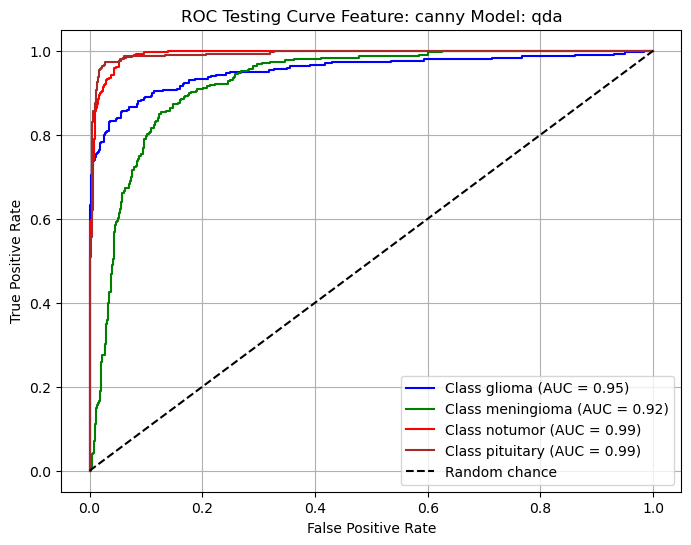

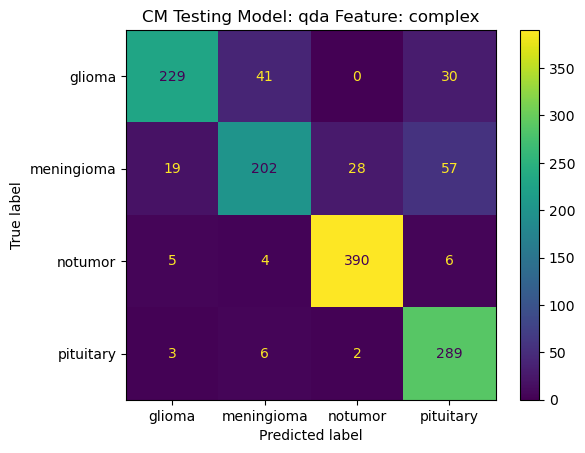

(1311, 4)


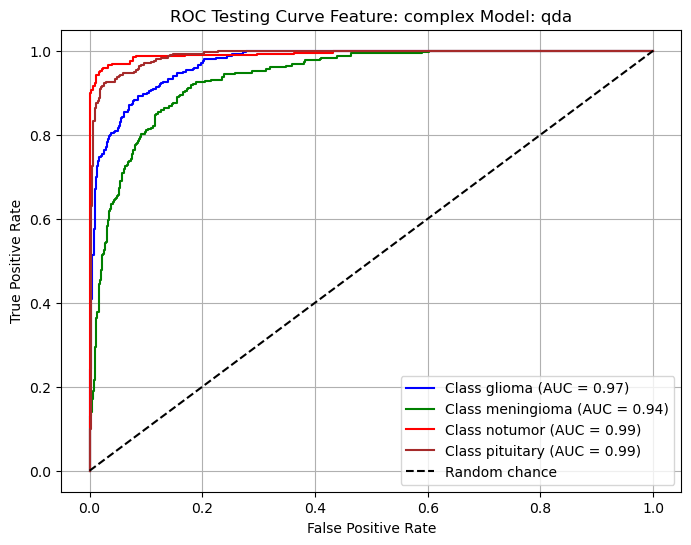

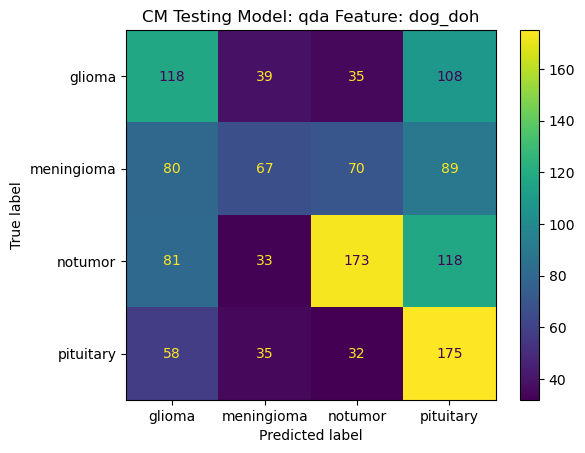

(1311, 4)


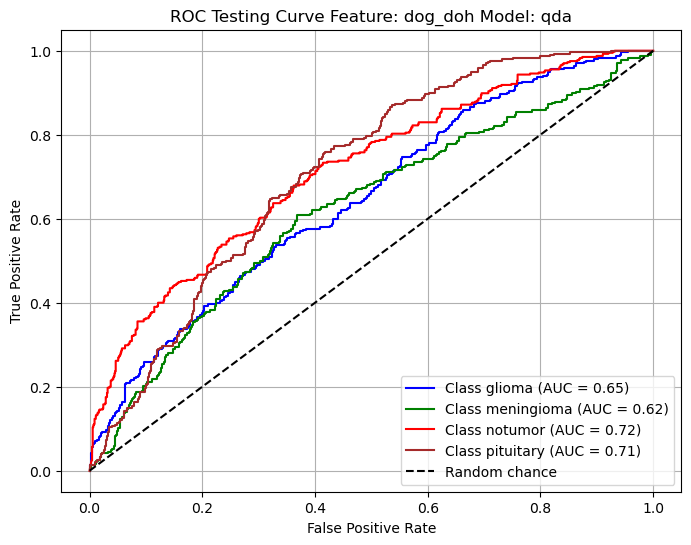

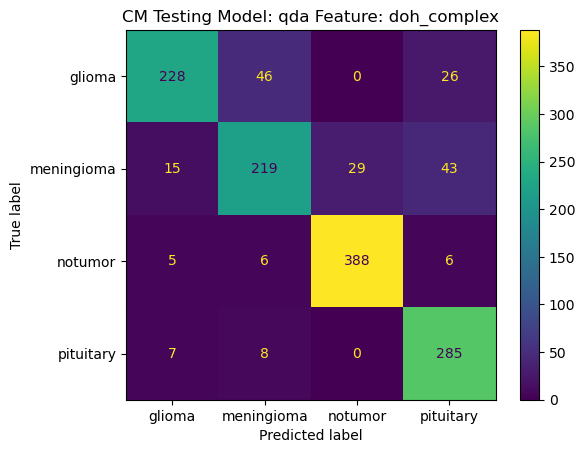

(1311, 4)


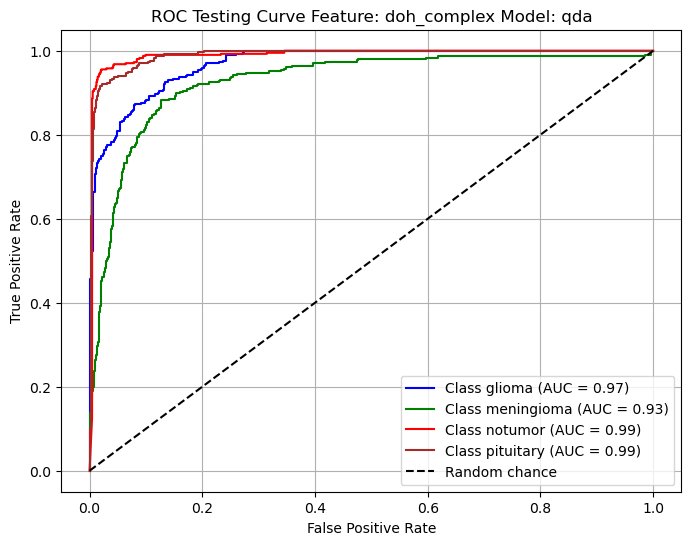

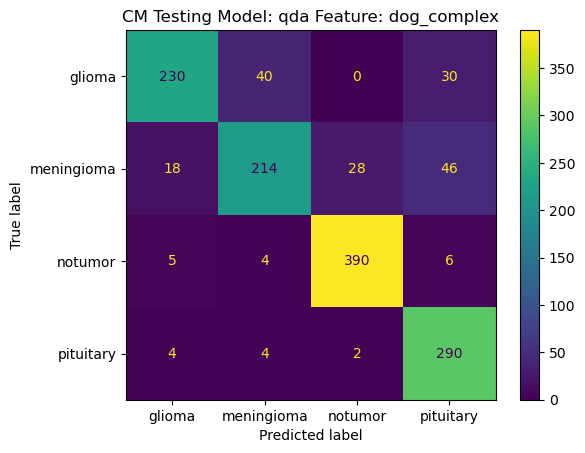

(1311, 4)


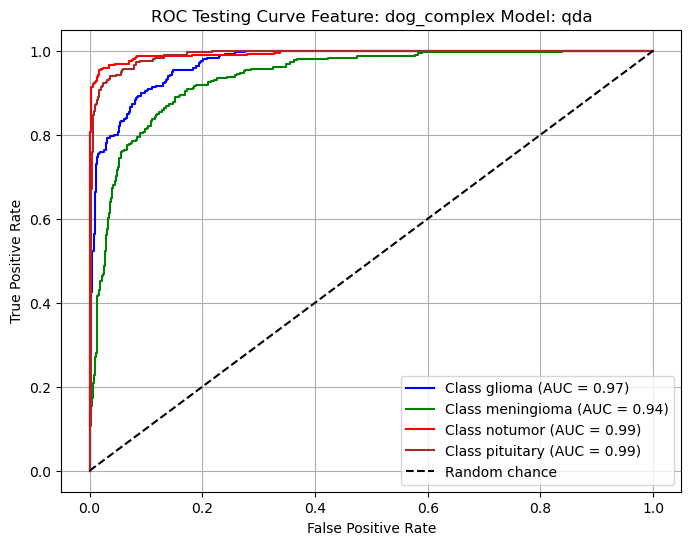

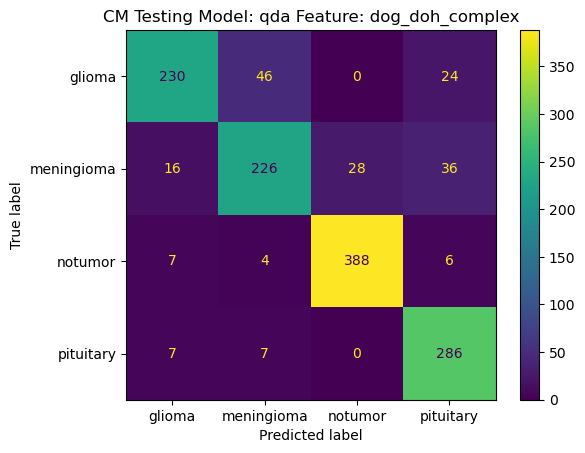

(1311, 4)


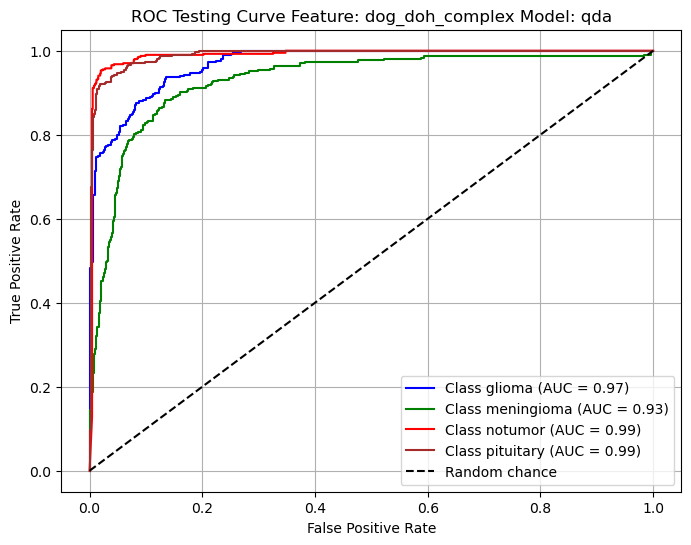

In [ ]:
aligned_test_features = pd.read_csv('extracted_features/aligned_testing_features.csv')
aligned_test_features, dims, enc = clean_df(
    df=aligned_test_features,
    label_col="target",
    feat_cols=["feat_canny", "feat_vec", "feat_dog", "feat_doh"]
)

parsed_aligned_test_features  = parse_aligned_features(aligned_test_features, ['feat_canny', 'feat_vec', 'feat_dog', 'feat_doh'])

X_test_dog_features = parsed_aligned_test_features['feat_dog']
X_test_doh_features = parsed_aligned_test_features['feat_doh']
X_test_complex_features = parsed_aligned_test_features['feat_vec']
X_test_canny_features = np.load('extracted_features/X_test_canny.npy')
y_test = parsed_aligned_test_features['target']

features = {'dog':X_test_dog_features,
            'doh':X_test_doh_features,
            'canny':X_test_canny_features,
            'complex': X_test_complex_features,
            'dog_doh': np.concatenate((X_test_dog_features, X_test_doh_features), axis=1),
            'doh_complex': np.concatenate((X_test_doh_features, X_test_complex_features), axis=1),
            'dog_complex': np.concatenate((X_test_dog_features, X_test_complex_features), axis=1),
            'dog_doh_complex': np.concatenate((X_test_dog_features, X_test_doh_features, X_test_complex_features), axis=1)
            }

all_test_results= pd.DataFrame(columns = ['feature', 'model_type', 'accuracy_score', 'macro_precision', 'macro_recall', 'macro_f1', 
                                      'micro_precision', 'micro_recall', 'micro_f1', 'inference_time'])

for model in loaded_models.keys():
    feature = model.split('_',1)[-1]
    model_type = model.split('_',1)[0]
    
    X_test = features[feature]

    result_dict = test_model(model_store[model], X_test, y_test, le.classes_, model_type=str(model_type), feature=str(feature))
    all_test_results.loc[len(all_test_results)] = result_dict

all_test_results.to_csv("results/test_results.csv")
